# Analyse der Auswirkungen von COVID-Fallzahlen auf Landeswährungen, Gold und Bitcoin 

## Teil 1: Statistische Analyse

Eine weltweite Krise wurde durch COVID ausgelöst. In fast allen Ländern hat dies zu massiven wirtschaftlichen Einbrüchen geführt, teilweise haben die Menschen ihr Vertrauen in Politik und Wirtschaft verloren. Deshalb wollen wir untersuchen, inwiefern COVID-19 die Entwicklung von Währungskursen beeinflusst hat und ob eine Flucht in alternative Anlagen wie Kryptowährungen oder Wertanlagen, in diesem Fall Bitcoin und Gold stattgefunden hat.
Als Datengrundlage dient/dienen
1. die Währungskurse (in Relation zum Euro)
2. der Bitcoinkurs (in Relation zu Dollar)
3. der Goldkurs (in Relation zum Euro)
4. die täglichen COVID-Neuinfektionen je Land
5. ein Datensatz, um Währungen und länderspezifische COVID-Zahlen zuweisen zu können

Da wir die statistischen Zusammenhänge zwischen den Datensätzen 1. bis 4. erfassen wollten, haben wir hauptsächlich die Regressionsanalyse, insbesondere den Regressionskoeffizienten, angewendet. Die Datensätze mussten aufbereitet werden, indem wir sie teilweise zu einem Data-frame verschmolzen oder tägliche Informationen zu prozentualen Veränderungen um-rechnen mussten.

Um die landesspezifischen COVID-Fälle mit den Landeswährungen in Bezug setzen zu können, ist Datensatz 5. notwendig. Dieser stellt die Verbindung zwischen Währungscode, bspw. CHF für Schweizer Franken und Ländercode, bspw. CHE für die Schweiz, her.

### 1.1 Vergleich von kombinierten Landeswährungen, Gold, COVID-19 und Bitcoin

Im ersten Schritt sollen die verschiedenen Verläufe verglichen werden. Hierfür sind folgende Vorarbeiten notwendig:
1. Datensätze aggregieren
2. Nach Datum indexieren
3. Prozentuale Veränderungen berechnen
4. „NaN“ und „inf“ ersetzen durch „0“ oder vorhergehenden Wert
5. optional
    1. Daten zusammenfassen und normalisieren
    2. Graphen plotten
6. Korrelation berechnen
7. nach Bedarf: Daten gruppieren oder zusätzlich pivotieren



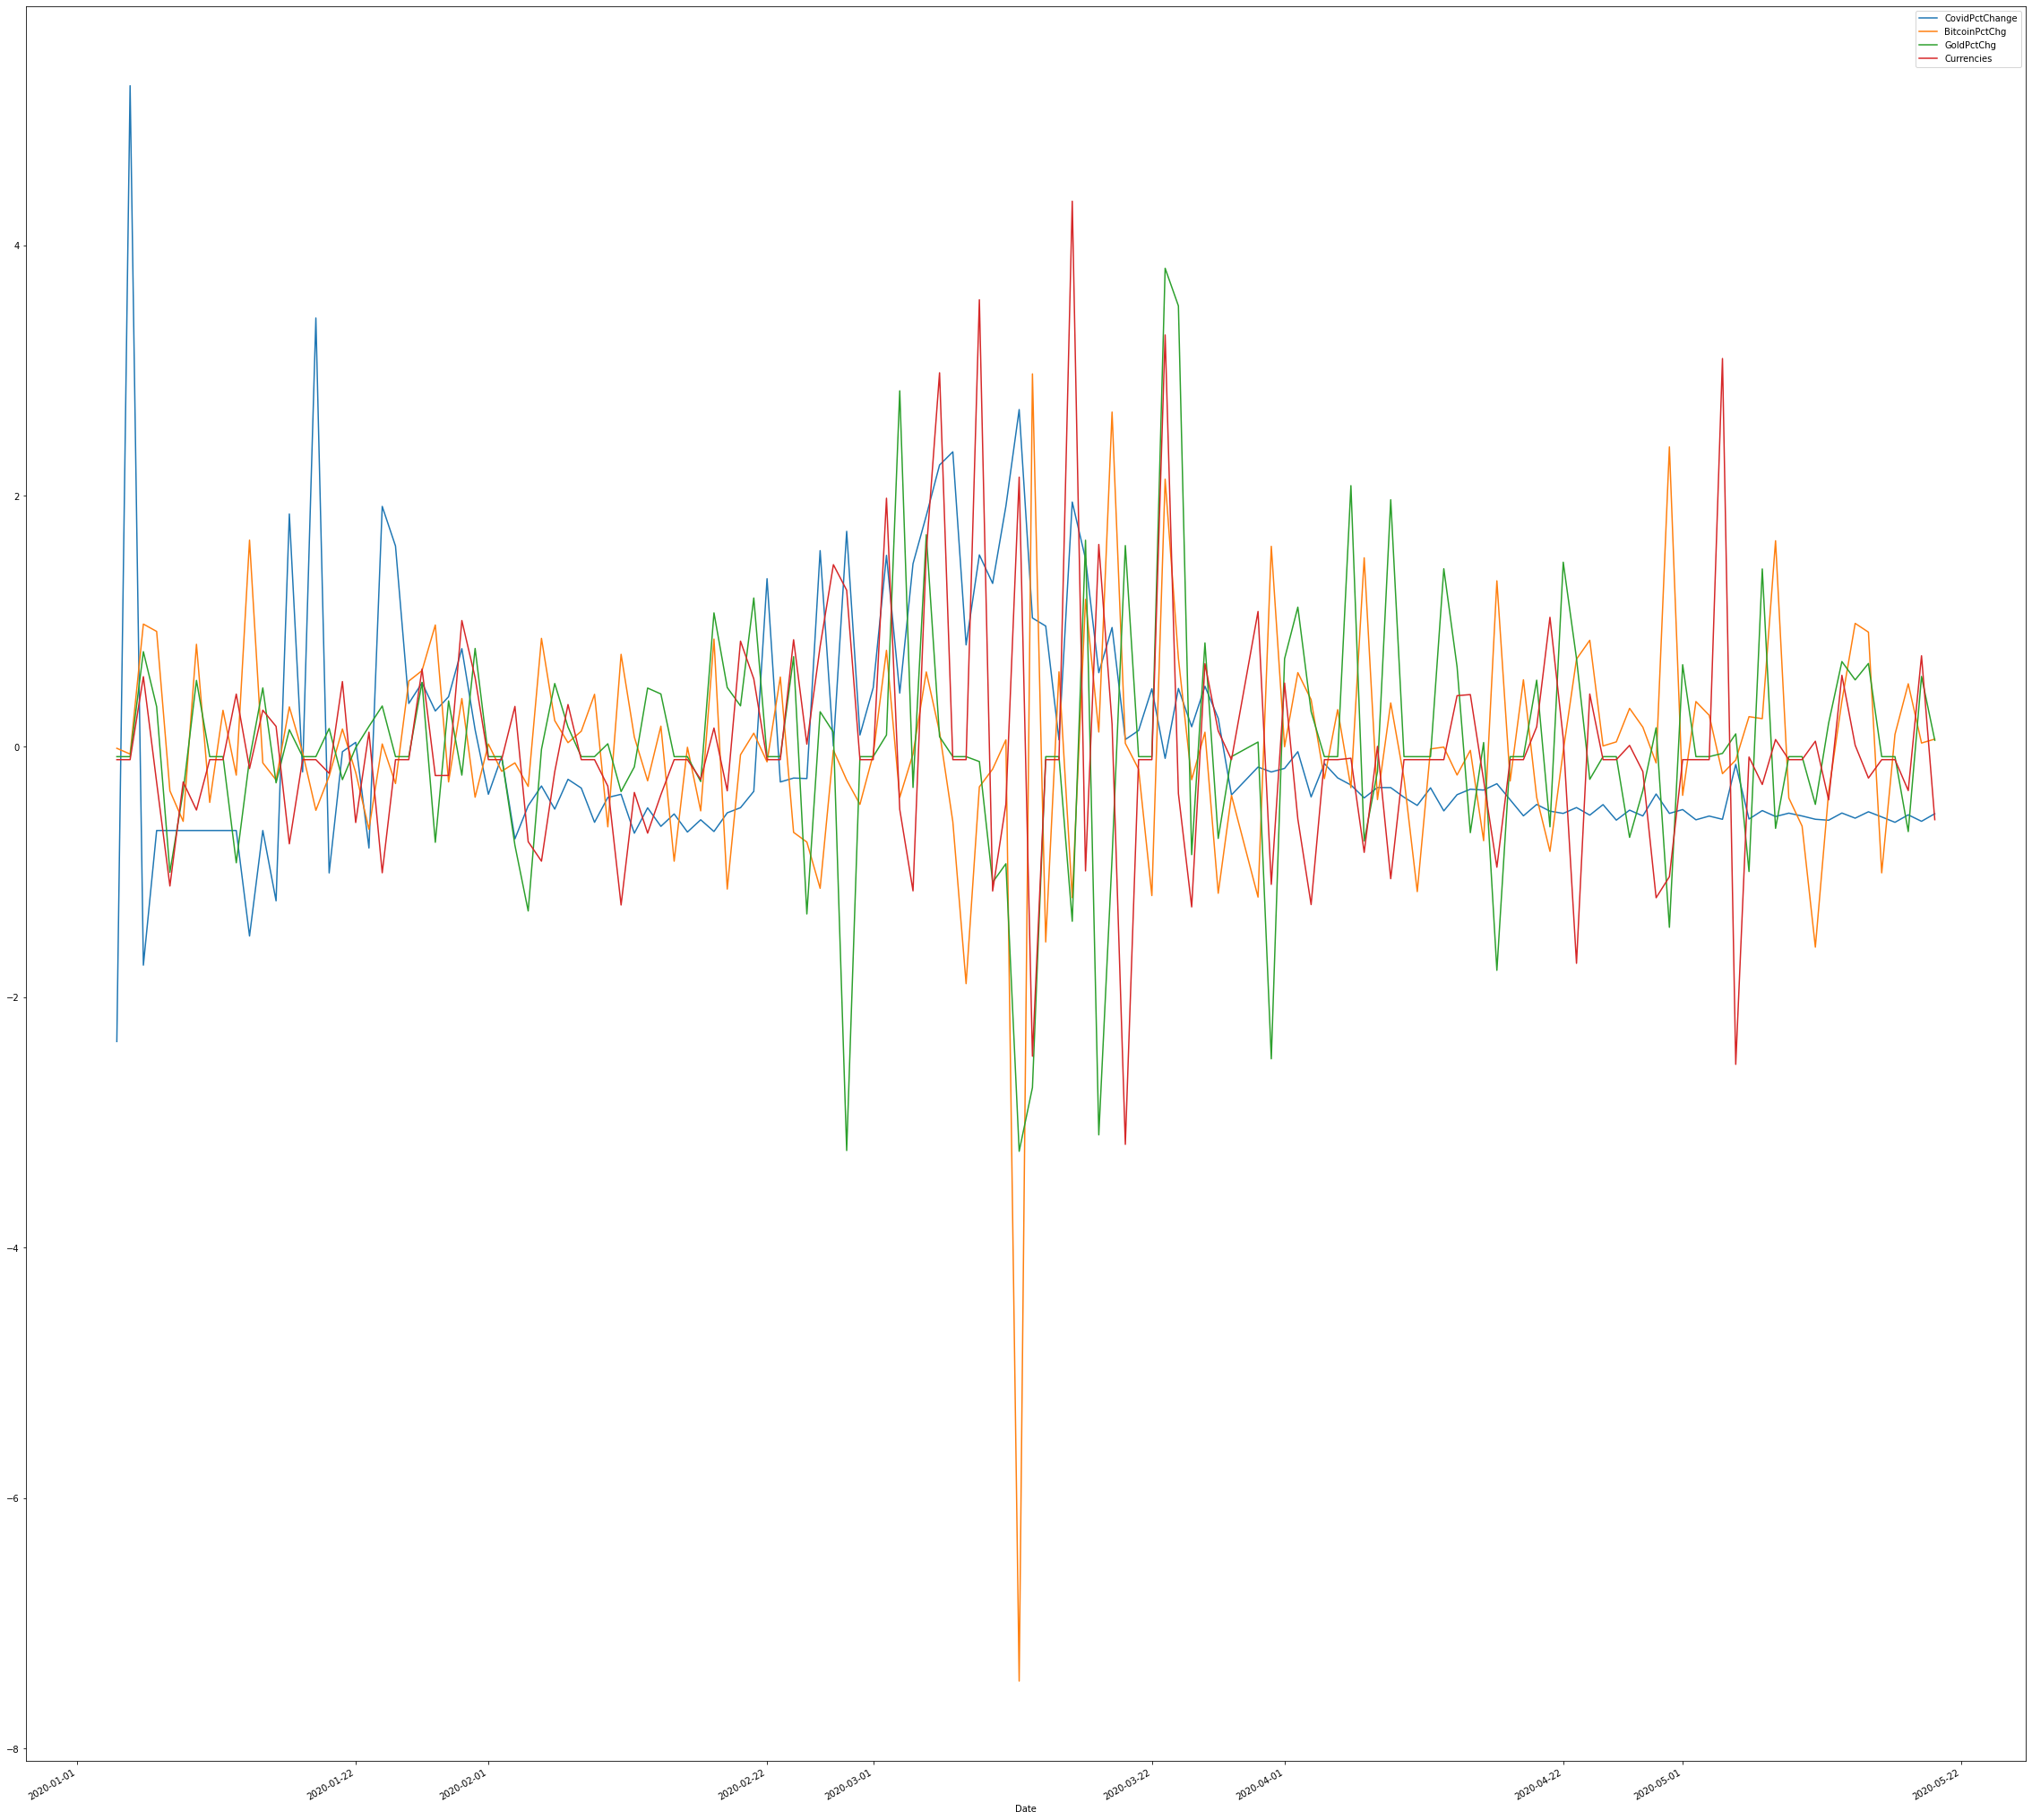

In [ ]:
#################################################################################################
#                                                                                               #
#   <Funktionsbeschreibung>                                                                     #
#                                                                                               #
#   Dieses Programm wurde für den Kurs Data-Science 1 an der Goethe-Uni Frankfurt erstellt      #
#   Betreuender Dozent: Dr. Karsten Toll                                                        #
#   Projektgruppe:                                                                              #
#       - plumbus (Nr. 108)                                                                     #
#       - Simon Fischer-Heselhaus                                                               #
#       - Bahram Salimi                                                                         #
#                                                                                               #
#################################################################################################

import pandas as pd
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import glob

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

scaler = StandardScaler()

pd.set_option("display.max_rows", None, "display.max_columns", None)

#################################################################################################
#                                                                                               #
#   Einlesen der Datensätze                                                                     #
#                                                                                               #
#################################################################################################

# COVID-19 Falldaten von  https://data.europa.eu/euodp/de/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590
filenameCovid = '../plumbus_data/covid_cases.csv'
# Datensatz für ISO-Codes von https://www.oenb.at/Statistik/Klassifikationen/ISO-Codes/ISO-Code-Verzeichnis-fuer-Laender--und-Waehrungscodes.html
filenameIso = '../plumbus_data/IsoCodes.csv'
# Datensatz für Währungen von https://www.commerzbank.de/de/hauptnavigation/kunden/kursinfo/devisenk/ezb_referenzkurse/archiv_3/ezb_archiv.jsp
filenameCurrenciesRates = '../plumbus_data/ecb_rates_DE_compl.csv'
# Datensatz für Bitcoinkurs https://www.blockchain.com/charts/market-price
filenameBitcoinRates = '../plumbus_data/market-price.csv'
# Datensatz für Goldkurs von https://www.ariva.de/goldpreis-gold-kurs/historische_kurse?boerse_id=130 
filenameGoldRates = '../plumbus_data/wkn_965515_historic.csv'

#Zusammenfassung mehrer Excel-Dateien zu einem Dataframe
dfCurrencies = pd.DataFrame()
dfCurrencies.insert(0, "Tagesdatum", [], True) 
dfCurrencies.insert(1, "Kalender-woche", [], True) 
for f in glob.glob("../plumbus_data/ecb_rates_DE*.xls"):
    dfCurr = pd.read_excel(f, skiprows=[0,1,2,4], header=0)
    dfCurrencies = pd.merge(dfCurrencies, dfCurr, left_on=["Tagesdatum","Kalender-woche"], right_on=["Tagesdatum","Kalender-woche"], how="right")
    
dfCovid = pd.read_csv(filenameCovid, header=0, delimiter=",")
dropCovidColumns = ["day","month","year","deaths","countryterritoryCode","popData2018","continentExp"]

#Kurs von BGN  schwankt symmetrisch zu Euro-Kurs -> Keine Kursveränderung -> führt zu Fehlern (singuläre Matrix)
dropCurrencies = ["BGN","Kalender-woche"]
dfCurrencies.drop(dropCurrencies,axis=1,inplace=True)

dfCovid.drop(dropCovidColumns,axis=1,inplace=True)
dfCovid = dfCovid.iloc[::-1]
dfCovid["dateRep"] = pd.to_datetime(dfCovid["dateRep"], format='%d/%m/%Y')

#dfIso nur relevant um Datensätze zu verbinden
dfIso = pd.read_csv(filenameIso, header=1, usecols=["ISO-Code Land", "ISO-Code Währung"], delimiter=";")

dfBitcoin = pd.read_csv(filenameBitcoinRates, header=0, delimiter=",")

dfGold = pd.read_csv(filenameGoldRates, usecols=["Datum", "Schlusskurs"], header=0, delimiter=";")

#Anpassung Datensatz von täglich neuen COVID-Fällen zu Gesamtfällen (Fälle aktueller Tag + alle Fälle aus allen Vortagen)
caseSum=0
for i in range(len(dfCovid)): 
    if i < len(dfCovid) and dfCovid.iloc[i,2] == dfCovid.iloc[i-1,2]:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    elif i == 0:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    else:
        caseSum=0

dfCovid.set_index("dateRep", inplace=True)
dfCovid["CovidPctChange"] = dfCovid.groupby(["geoId"]).cases.pct_change()
dfCovid.reset_index(drop=False, inplace=True)
dfCovidGlobal = dfCovid[~dfCovid.isin([np.nan, np.inf, -np.inf]).any(1)].groupby(["dateRep"]).CovidPctChange.mean().to_frame()

#Range (Datumanfang - Datumende) der Datensätze wird indexiert
dfCurrencies.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfCurrencies.index=pd.to_datetime(dfCurrencies["Tagesdatum"], format="%d.%m.%Y")
#Range (Datumanfang - Datumende) der Datensätze wird indexiert
dfCurrencies = dfCurrencies.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfCurrencies = dfCurrencies.iloc[:,1:].astype(float)
dfCurrencies = dfCurrencies.pct_change(fill_method='ffill')
dfCurrenciesT = dfCurrencies.T.mean()
romean = dfCurrenciesT.rolling(window=100, min_periods=1).mean()

#Zusammenfassung aller Kursschwankungen (gibt es einen allgemeinen Trend für Währungen?)
dfCurrenciesCombined = dfCurrencies.mean(axis = 1, skipna = True)

#Normalisierung der Daten, erleichtert graphische Darstellung
dfBitcoin.index=pd.to_datetime(pd.DatetimeIndex(dfBitcoin["Timestamp"]).normalize(), format="")
dfBitcoin.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfBitcoin = dfBitcoin.iloc[:,1:]
dfBitcoin = dfBitcoin.pct_change(fill_method ='ffill') #Umrechnung zu prozentualen Veränderungen, fehlende Werte werden gefüllt
dfBitcoin.rename(columns={'market-price':'BitcoinPctChg'}, inplace=True)

dfGold.index=pd.to_datetime(pd.DatetimeIndex(dfGold["Datum"]).normalize(), format="%Y-%m-%d")
dfGold = dfGold.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfGold.index.name = 'Datum'
dfGold = dfGold.iloc[:,1:].replace({'[.]':'','[,]':'.'}, regex=True).astype(float)
dfGold = dfGold.pct_change(fill_method='ffill')
dfGold.rename(columns={'Schlusskurs':'GoldPctChg'}, inplace=True)

#Zusammenfassen der Dataframes
dfCovidBitcoinGoldCurrenciesGlobal = pd.merge(dfCovidGlobal, dfBitcoin, left_index=True, right_index=True)
dfCovidBitcoinGoldCurrenciesGlobal = pd.merge(dfCovidBitcoinGoldCurrenciesGlobal, dfGold, left_index=True, right_index=True)
dfCovidBitcoinGoldCurrenciesGlobal = pd.merge(dfCovidBitcoinGoldCurrenciesGlobal, dfCurrenciesCombined.to_frame(name="Currencies"), left_index=True, right_index=True)

names = dfCovidBitcoinGoldCurrenciesGlobal.columns
scaler = StandardScaler()
dfCovidBitcoinGoldCurrenciesGlobal_scaled = scaler.fit_transform(dfCovidBitcoinGoldCurrenciesGlobal)
dfCovidBitcoinGoldCurrenciesGlobal_scaled = pd.DataFrame(dfCovidBitcoinGoldCurrenciesGlobal_scaled, columns=names)
dfCovidBitcoinGoldCurrenciesGlobal_scaled["Date"] = dfCovidBitcoinGoldCurrenciesGlobal.index
dfCovidBitcoinGoldCurrenciesGlobal_scaled.set_index("Date", inplace=True)
dfCovidBitcoinGoldCurrenciesGlobal_scaled.plot(figsize=(40,40))

Anhand des Graphen wird Folgendes ersichtlich: Mit Anstieg der COVID-Fälle kam es zu starken Fluktuationen des Bitcoin-Kurses, zu beachten ist insbesondere der starke Kursverlust Mitte März. Die kombinierten Landeswährungen gleichen sich teilweise gegenseitig aus, daher ist die Amplitude gering, allerdings ist trotzdem eine hohe Fluktuation zu erkennen. Außerdem ist zu beachten, dass alle Währungen im Vergleich zum Euro dargestellt sind. Für den Bitcoinkurs konnten nur Daten auf Basis des US-Dollar gefunden werden.

### 1.2 Zusammenhänge zwischen Landeswährungen, Bitcoin und COVID

Wie bereits angedeutet, können sich Währungsentwicklungen teilweise gegenseitig ausgleichen, wobei hier nur Kursveränderungen berücksichtigt werden und keine tatsächlichen Währungsvolumina. Deshalb erscheint es sinnvoll, Währungen nach Ländern zu unterteilen und diese mit der allgemeinen COVID-Entwicklung zu vergleichen.

([<matplotlib.axis.YTick at 0x269bd0a0>,
 [Text(0, 0, 'HRK'),
  Text(0, 0, 'ILS'),
  Text(0, 0, 'ISK'),
  Text(0, 0, 'KRW'),
  Text(0, 0, 'MXN'),
  Text(0, 0, 'MYR'),
  Text(0, 0, 'PHP'),
  Text(0, 0, 'PLN'),
  Text(0, 0, 'RON'),
  Text(0, 0, 'RUB'),
  Text(0, 0, 'SGD'),
  Text(0, 0, 'THB'),
  Text(0, 0, 'ZAR'),
  Text(0, 0, 'AUD'),
  Text(0, 0, 'BRL'),
  Text(0, 0, 'CAD'),
  Text(0, 0, 'CHF'),
  Text(0, 0, 'DKK'),
  Text(0, 0, 'GBP'),
  Text(0, 0, 'HKD'),
  Text(0, 0, 'IDR'),
  Text(0, 0, 'INR'),
  Text(0, 0, 'JPY'),
  Text(0, 0, 'NOK'),
  Text(0, 0, 'NZD'),
  Text(0, 0, 'SEK'),
  Text(0, 0, 'USD'),
  Text(0, 0, 'CNY'),
  Text(0, 0, 'CZK'),
  Text(0, 0, 'HUF'),
  Text(0, 0, 'TRY'),
  Text(0, 0, 'BitcoinPctChg'),
  Text(0, 0, 'CovidPctChange'),
  Text(0, 0, 'GoldPctChg')])

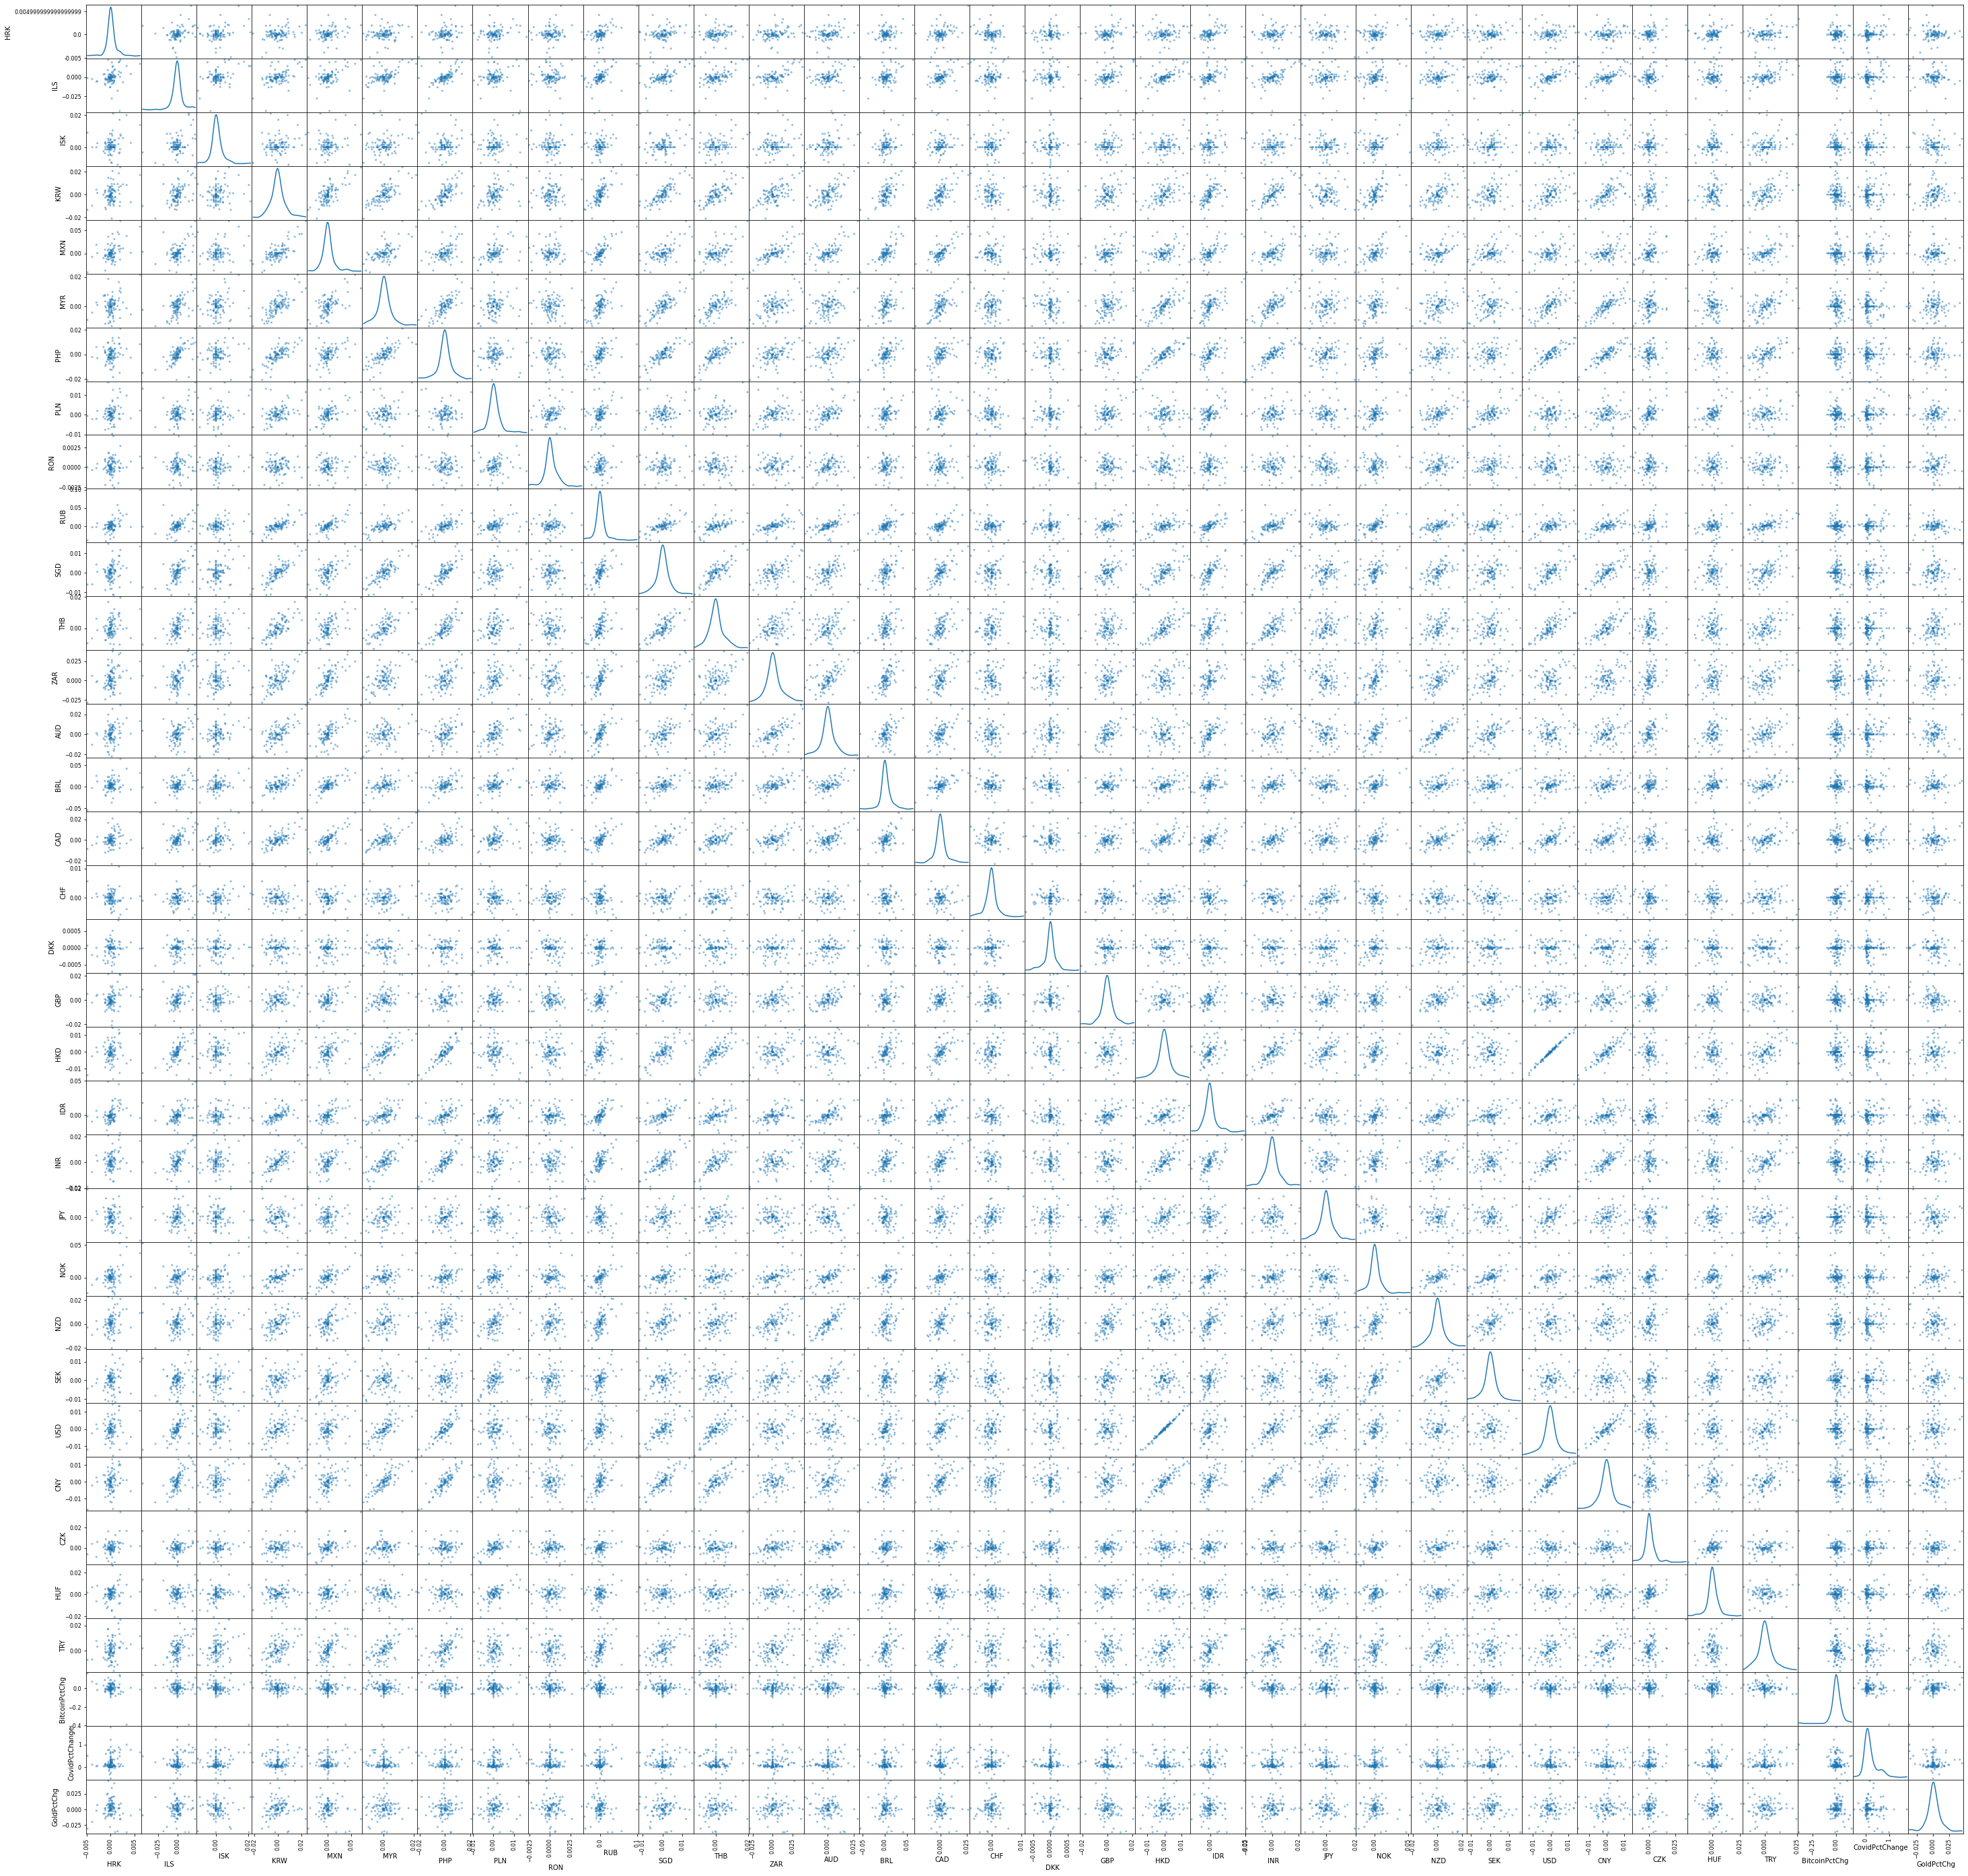

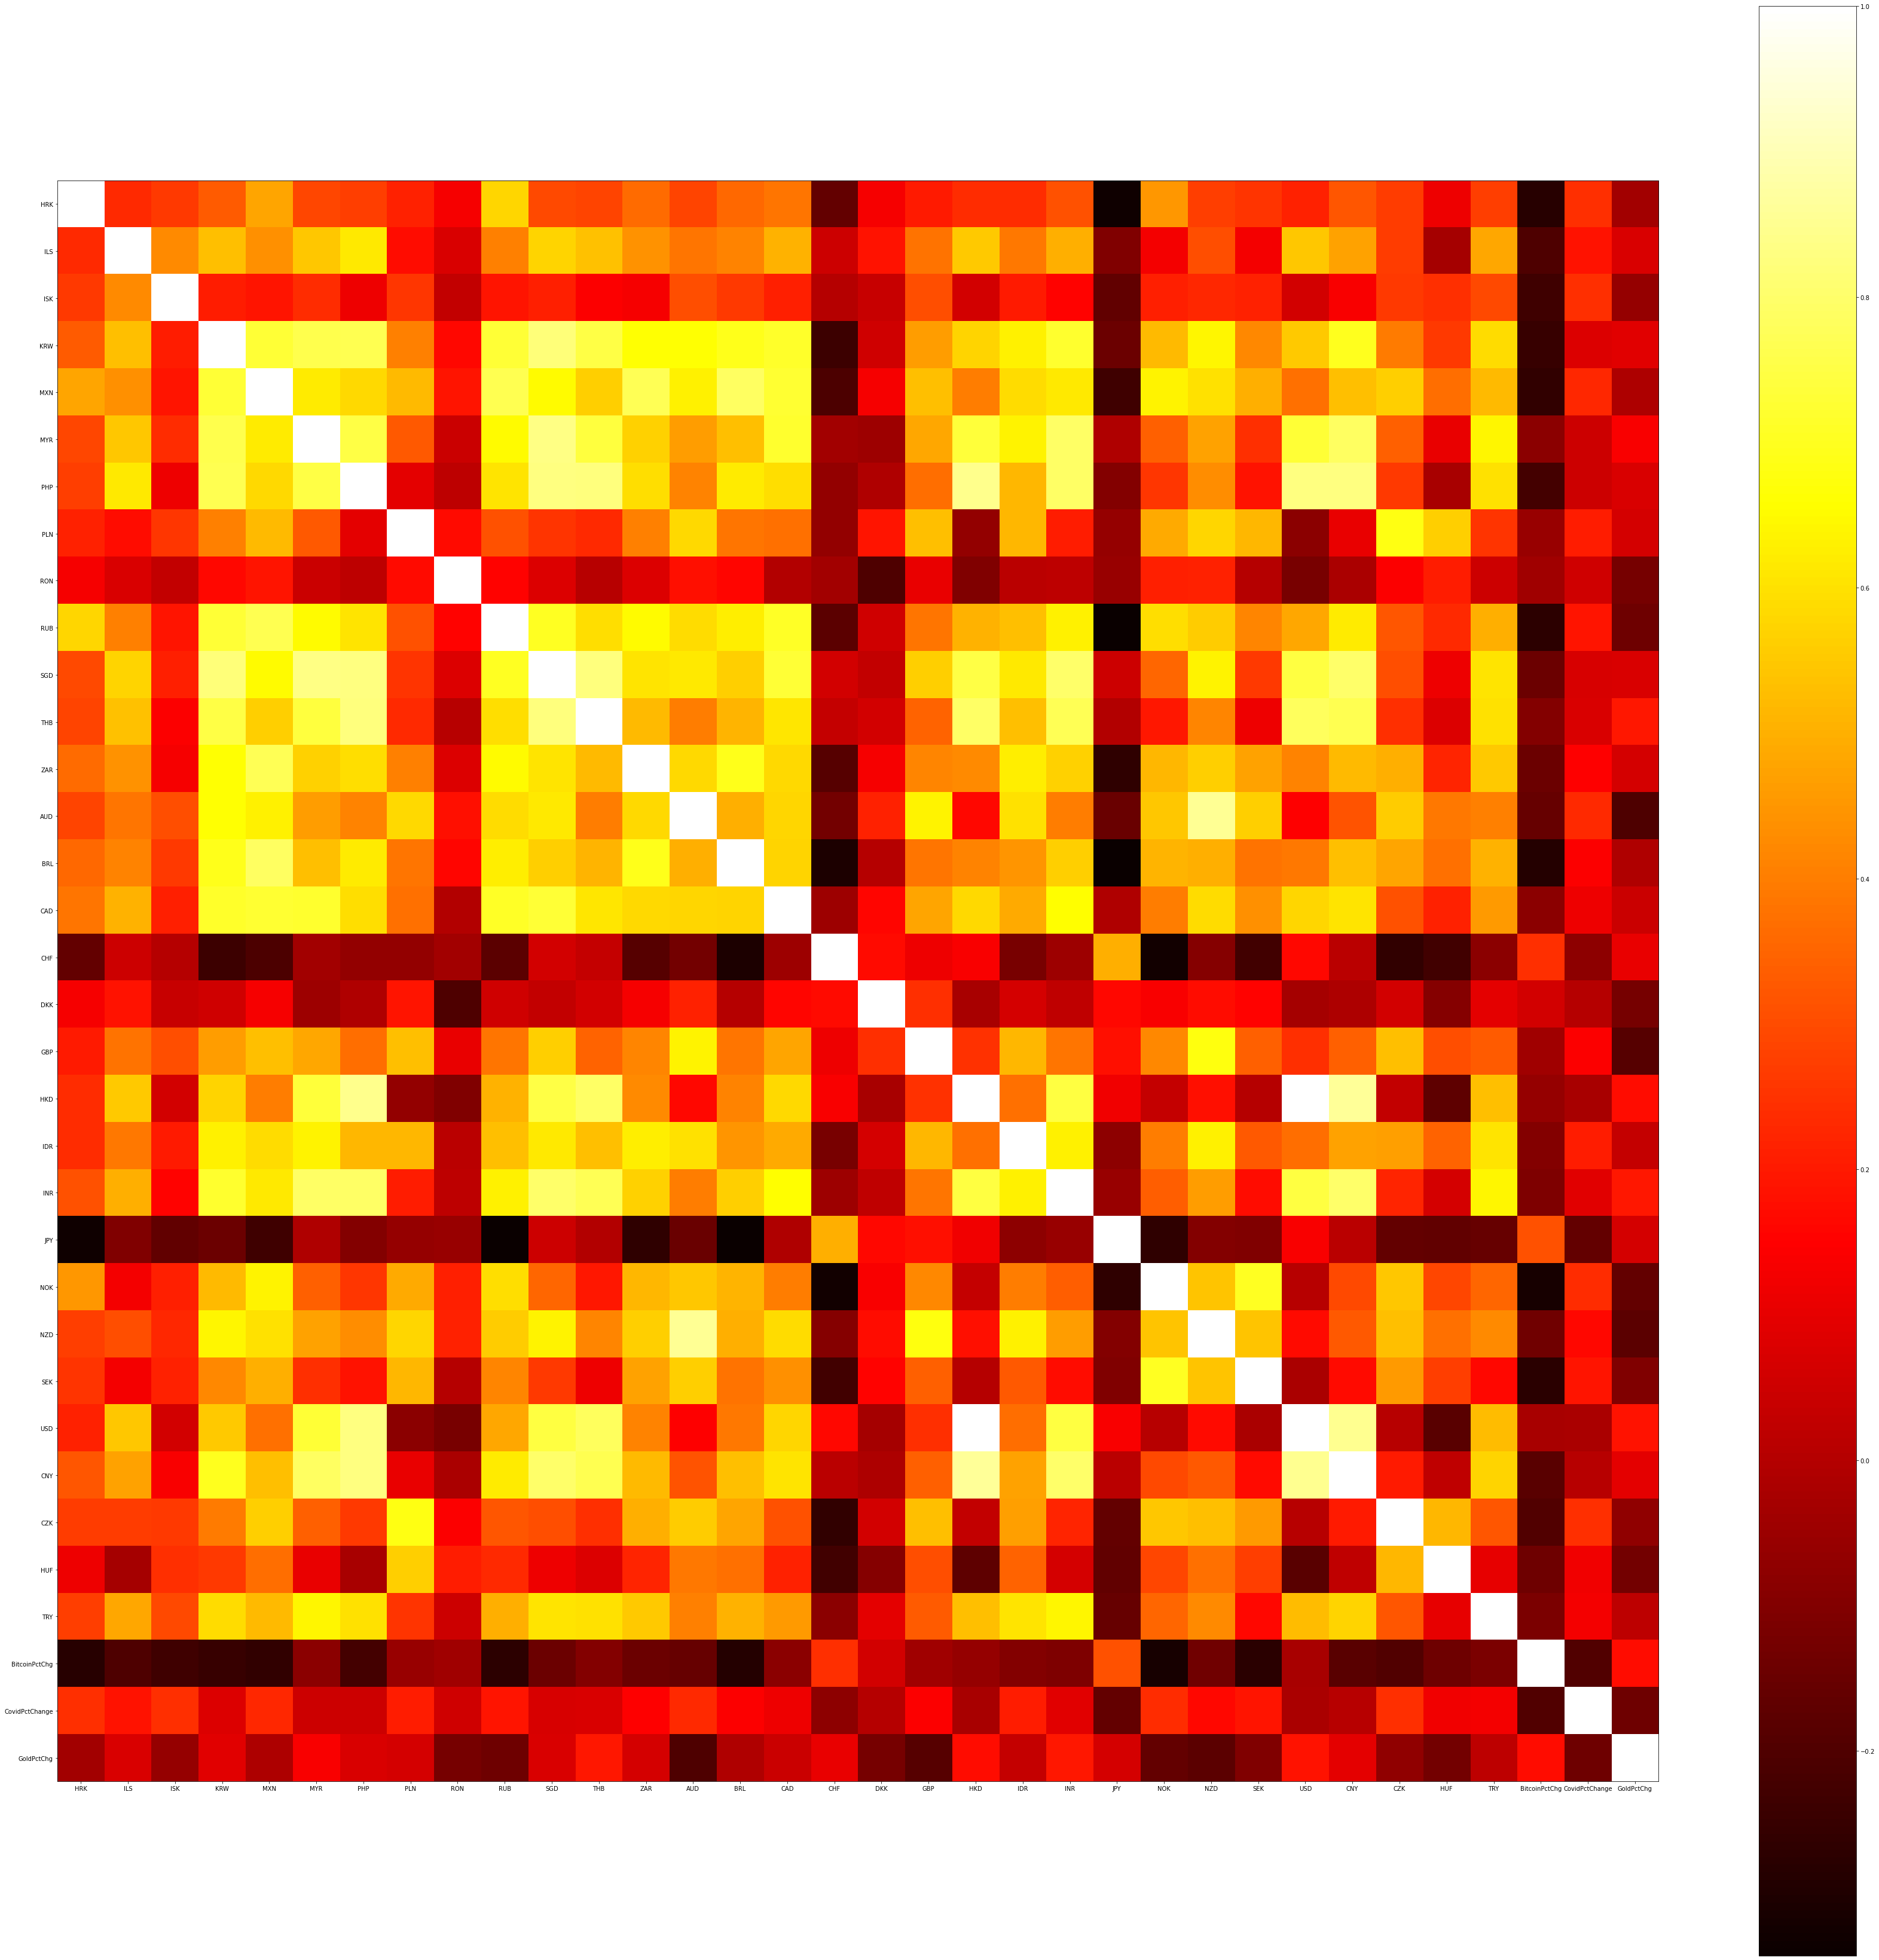

In [ ]:
#################################################################################################
#                                                                                               #
#   <Funktionsbeschreibung>  Heatmap der Landeswährung, Bitcoin und COVID                       #
#                                                                                               #
#   Dieses Programm wurde für den Kurs Data-Science 1 an der Goethe-Uni Frankfurt erstellt      #
#   Betreuender Dozent: Dr. Karsten Toll                                                        #
#   Projektgruppe:                                                                              #
#       - plumbus (Nr. 108)                                                                     #
#       - Simon Fischer-Heselhaus                                                               #
#       - Bahram Salimi                                                                         #
#                                                                                               #
#################################################################################################

import pandas as pd
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import glob

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

scaler = StandardScaler()

pd.set_option("display.max_rows", None, "display.max_columns", None)

#################################################################################################
#                                                                                               #
#   Einlesen der Datensätze                                                                     #
#                                                                                               #
#################################################################################################

# COVID-19 Falldaten von  https://data.europa.eu/euodp/de/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590
filenameCovid = '../plumbus_data/covid_cases.csv'
# Datensatz für ISO-Codes von https://www.oenb.at/Statistik/Klassifikationen/ISO-Codes/ISO-Code-Verzeichnis-fuer-Laender--und-Waehrungscodes.html
filenameIso = '../plumbus_data/IsoCodes.csv'
# Datensatz für Währungen von https://www.commerzbank.de/de/hauptnavigation/kunden/kursinfo/devisenk/ezb_referenzkurse/archiv_3/ezb_archiv.jsp
filenameCurrenciesRates = '../plumbus_data/ecb_rates_DE_compl.csv'
# Datensatz für Bitcoinkurs https://www.blockchain.com/charts/market-price
filenameBitcoinRates = '../plumbus_data/market-price.csv'
# Datensatz für Goldkurs von https://www.ariva.de/goldpreis-gold-kurs/historische_kurse?boerse_id=130 
filenameGoldRates = '../plumbus_data/wkn_965515_historic.csv'

#Zusammenfassung mehrer Excel-Dateien zu einem Dataframe
dfCurrencies = pd.DataFrame()
dfCurrencies.insert(0, "Tagesdatum", [], True) 
dfCurrencies.insert(1, "Kalender-woche", [], True) 
for f in glob.glob("../plumbus_data/ecb_rates_DE*.xls"):
    dfCurr = pd.read_excel(f, skiprows=[0,1,2,4], header=0)
    dfCurrencies = pd.merge(dfCurrencies, dfCurr, left_on=["Tagesdatum","Kalender-woche"], right_on=["Tagesdatum","Kalender-woche"], how="right",)

dfCovid = pd.read_csv(filenameCovid, header=0, delimiter=",")
dropCovidColumns = ["day","month","year","deaths","countryterritoryCode","popData2018","continentExp"]

#Kurs von BGN  schwankt symmetrisch zu Euro-Kurs -> Keine Kursveränderung -> führt zu Fehlern (singuläre Matrix)
dropCurrencies = ["BGN","Kalender-woche"]
dfCurrencies.drop(dropCurrencies,axis=1,inplace=True)

dfCovid.drop(dropCovidColumns,axis=1,inplace=True)
dfCovid = dfCovid.iloc[::-1]
dfCovid["dateRep"] = pd.to_datetime(dfCovid["dateRep"], format='%d/%m/%Y')

#dfIso nur relevant um Datensätze zu verbinden
dfIso = pd.read_csv(filenameIso, header=1, usecols=["ISO-Code Land", "ISO-Code Währung"], delimiter=";")

dfBitcoin = pd.read_csv(filenameBitcoinRates, header=0, delimiter=",")

dfGold = pd.read_csv(filenameGoldRates, usecols=["Datum", "Schlusskurs"], header=0, delimiter=";")

#Anpassung Datensatz von täglich neuen COVID-Fällen zu Gesamtfällen (Fälle aktueller Tag + alle Fälle aus allen Vortagen)
caseSum=0
for i in range(len(dfCovid)): 
    if i < len(dfCovid) and dfCovid.iloc[i,2] == dfCovid.iloc[i-1,2]:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    elif i == 0:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    else:
        caseSum=0

dfCovid.set_index("dateRep", inplace=True)
dfCovid["CovidPctChange"] = dfCovid.groupby(["geoId"]).cases.pct_change()
dfCovid.reset_index(drop=False, inplace=True)
dfCovidGlobal = dfCovid[~dfCovid.isin([np.nan, np.inf, -np.inf]).any(1)].groupby(["dateRep"]).CovidPctChange.mean().to_frame()

dfCurrencies.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfCurrencies.index=pd.to_datetime(dfCurrencies["Tagesdatum"], format="%d.%m.%Y")
dfCurrencies = dfCurrencies.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfCurrencies = dfCurrencies.iloc[:,1:].astype(float)
dfCurrencies = dfCurrencies.pct_change(fill_method='ffill')
dfCurrenciesT = dfCurrencies.T.mean()
romean = dfCurrenciesT.rolling(window=100, min_periods=1).mean()

#Zusammenfassung aller Kursschwankungen (gibt es einen allgemeinen Trend für Währungen?)
dfCurrenciesCombined = dfCurrencies.mean(axis = 1, skipna = True)

dfBitcoin.index=pd.to_datetime(pd.DatetimeIndex(dfBitcoin["Timestamp"]).normalize(), format="")
dfBitcoin.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfBitcoin = dfBitcoin.iloc[:,1:]
dfBitcoin = dfBitcoin.pct_change(fill_method ='ffill')
dfBitcoin.rename(columns={'market-price':'BitcoinPctChg'}, inplace=True)

dfGold.index=pd.to_datetime(pd.DatetimeIndex(dfGold["Datum"]).normalize(), format="%Y-%m-%d")
dfGold = dfGold.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfGold.index.name = 'Datum'
dfGold = dfGold.iloc[:,1:].replace({'[.]':'','[,]':'.'}, regex=True).astype(float)
dfGold = dfGold.pct_change(fill_method='ffill')
dfGold.rename(columns={'Schlusskurs':'GoldPctChg'}, inplace=True)

#Zusammenfassen der Dataframes
dfCurrenciesWithCrypto = dfCurrencies.join(dfBitcoin, how='right')
dfCurrenciesWithCryptoCovid = dfCurrenciesWithCrypto.join(dfCovidGlobal, how='left')
dfCurrenciesCryptoCovidGold = dfCurrenciesWithCryptoCovid.join(dfGold, how='left')

correlationCurrCrypCovGold = dfCurrenciesCryptoCovidGold.corr()

#Scattermatrix: Funktioniert nur ohne Währung "BGN"
pd.plotting.scatter_matrix(dfCurrenciesCryptoCovidGold, diagonal='kde', figsize=(50, 50))

#Heatmap generieren
plt.figure(figsize=(60,60))
plt.imshow(correlationCurrCrypCovGold, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlationCurrCrypCovGold)), correlationCurrCrypCovGold.columns)
plt.yticks(range(len(correlationCurrCrypCovGold)), correlationCurrCrypCovGold.columns)

Hier stechen mehrere Daten hervor: In der Heatmap sind, abseits der Diagonalen, einige Felder erkenntlich, die auf eine Korrelation von 1 hinweisen. HKD (Hongkong-Dollar) sind - mit einer gewissen Flexibilität - an USD (US-Dollar) gekoppelt. Außerdem fallen YEN (Japanische Yen) und Bitcoin auf, beide weisen eine vergleichsweise hohe negative Korrelation zu fast allen anderen Währungen auf, trotzdem sind dies überwiegend geringe Korrelationen unter |0,3|.

#### 1.2.1 Landeswährungen und COVID
Allgemein fallen die Korrelationen zwischen Landeswährungen und COVID gering aus. Koeffizienten von r=0,1 werden als "small effect size", r=0,3 als medium effect size und r=0,5 als "large effect size" bezeichnet, vgl. Cohen (1988, Statistical, S.79-81). Alle Korrelationen unter 0,3 werden wir daher aufgrund ihrer geringen Effekte an dieser Stelle nicht näher erläutern.

In [ ]:
#################################################################################################
#                                                                                               #
#   <Funktionsbeschreibung> Landeswährung & COVID                                               #
#                                                                                               #
#   Dieses Programm wurde für den Kurs Data-Science 1 an der Goethe-Uni Frankfurt erstellt      #
#   Betreuender Dozent: Dr. Karsten Toll                                                        #
#   Projektgruppe:                                                                              #
#       - plumbus (Nr. 108)                                                                     #
#       - Simon Fischer-Heselhaus                                                               #
#       - Bahram Salimi                                                                         #
#                                                                                               #
#################################################################################################
import pandas as pd
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import glob

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

scaler = StandardScaler()

pd.set_option("display.max_rows", None, "display.max_columns", None)



#################################################################################################
#                                                                                               #
#   Einlesen der Datensätze                                                                     #
#                                                                                               #
#################################################################################################

# COVID-19 Falldaten von  https://data.europa.eu/euodp/de/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590
filenameCovid = '../plumbus_data/covid_cases.csv'
# Datensatz für ISO-Codes von https://www.oenb.at/Statistik/Klassifikationen/ISO-Codes/ISO-Code-Verzeichnis-fuer-Laender--und-Waehrungscodes.html
filenameIso = '../plumbus_data/IsoCodes.csv'
# Datensatz für Währungen von https://www.commerzbank.de/de/hauptnavigation/kunden/kursinfo/devisenk/ezb_referenzkurse/archiv_3/ezb_archiv.jsp
filenameCurrenciesRates = '../plumbus_data/ecb_rates_DE_compl.csv'
# Datensatz für Bitcoinkurs https://www.blockchain.com/charts/market-price
filenameBitcoinRates = '../plumbus_data/market-price.csv'
# Datensatz für Goldkurs von https://www.ariva.de/goldpreis-gold-kurs/historische_kurse?boerse_id=130 
filenameGoldRates = '../plumbus_data/wkn_965515_historic.csv'



dfCurrencies = pd.DataFrame()
dfCurrencies.insert(0, "Tagesdatum", [], True) 
dfCurrencies.insert(1, "Kalender-woche", [], True) 
for f in glob.glob("../plumbus_data/ecb_rates_DE*.xls"):
    dfCurr = pd.read_excel(f, skiprows=[0,1,2,4], header=0)
    dfCurrencies = pd.merge(dfCurrencies, dfCurr, left_on=["Tagesdatum","Kalender-woche"], right_on=["Tagesdatum","Kalender-woche"], how="right",)


dfCovid = pd.read_csv(filenameCovid, header=0, delimiter=",")
dropCovidColumns = ["day","month","year","deaths","countryterritoryCode","popData2018","continentExp"]

#Kurs von BGN  schwankt symmetrisch zu Euro-Kurs -> Keine Kursveränderung
dropCurrencies = ["BGN","Kalender-woche"]
dfCurrencies.drop(dropCurrencies,axis=1,inplace=True)

dfCovid.drop(dropCovidColumns,axis=1,inplace=True)
dfCovid = dfCovid.iloc[::-1]
dfCovid["dateRep"] = pd.to_datetime(dfCovid["dateRep"], format='%d/%m/%Y')

dfIso = pd.read_csv(filenameIso, header=1, usecols=["ISO-Code Land", "ISO-Code Währung"], delimiter=";")

dfBitcoin = pd.read_csv(filenameBitcoinRates, header=0, delimiter=",")

dfGold = pd.read_csv(filenameGoldRates, usecols=["Datum", "Schlusskurs"], header=0, delimiter=";")


caseSum=0
for i in range(len(dfCovid)): 
    if i < len(dfCovid) and dfCovid.iloc[i,2] == dfCovid.iloc[i-1,2]:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    elif i == 0:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    else:
        caseSum=0

dfCovid.set_index("dateRep", inplace=True)
dfCovid["CovidPctChange"] = dfCovid.groupby(["geoId"]).cases.pct_change()
dfCovid.reset_index(drop=False, inplace=True)

dfCovidGlobal = dfCovid[~dfCovid.isin([np.nan, np.inf, -np.inf]).any(1)].groupby(["dateRep"]).CovidPctChange.mean().to_frame()

dfCurrencies.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfCurrencies.index=pd.to_datetime(dfCurrencies["Tagesdatum"], format="%d.%m.%Y")
dfCurrencies = dfCurrencies.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfCurrencies = dfCurrencies.iloc[:,1:].astype(float)
dfCurrencies = dfCurrencies.pct_change(fill_method='ffill')

dfCurrenciesCombined = dfCurrencies.mean(axis = 1, skipna = True)

#Bitcoinkurs
dfBitcoin.index=pd.to_datetime(pd.DatetimeIndex(dfBitcoin["Timestamp"]).normalize(), format="")
dfBitcoin.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfBitcoin = dfBitcoin.iloc[:,1:]
dfBitcoin = dfBitcoin.pct_change(fill_method ='ffill')
dfBitcoin.rename(columns={'market-price':'BitcoinPctChg'}, inplace=True)

#Goldkurs
dfGold.index=pd.to_datetime(pd.DatetimeIndex(dfGold["Datum"]).normalize(), format="%Y-%m-%d")
dfGold = dfGold.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfGold.index.name = 'Datum'
dfGold = dfGold.iloc[:,1:].replace({'[.]':'','[,]':'.'}, regex=True).astype(float)
dfGold = dfGold.pct_change(fill_method='ffill')
dfGold.rename(columns={'Schlusskurs':'GoldPctChg'}, inplace=True)

#sortierte Korrelationen: Landeswährungen vs. Covid
dfCurrenciesWithCrypto = dfCurrencies.join(dfBitcoin, how='right')
dfCurrenciesWithCryptoCovid = dfCurrenciesWithCrypto.join(dfCovidGlobal, how='left')

dfCurrenciesCryptoCovidGold = dfCurrenciesWithCryptoCovid.join(dfGold, how='left')

correlationCurrCrypCovGold = dfCurrenciesCryptoCovidGold.corr()

#sortieren nach Korrelation:
sortedCorrBitCurrCovGold = correlationCurrCrypCovGold
sortedCorrBitCurrCovGold = sortedCorrBitCurrCovGold.unstack()
sortedCorrBitCurrCovGold = sortedCorrBitCurrCovGold.sort_values(kind="quicksort").drop_duplicates()
dfsortedCorrBitCurrCovGold = pd.DataFrame(sortedCorrBitCurrCovGold)
dfsortedCorrBitCurrCovGold.rename(columns={dfsortedCorrBitCurrCovGold.columns[0]:'Corr'}, inplace=True)

dfsortedCorrCovidCurrencies = pd.concat([dfsortedCorrBitCurrCovGold.xs("CovidPctChange", level=1), dfsortedCorrBitCurrCovGold.xs("CovidPctChange", level=0)])
dfsortedCorrCovidCurrencies.sort_values(by=["Corr"], ascending=True, inplace=True, kind='quicksort')
dfsortedCorrCovidCurrencies
#dfsortedCorrCovidCurrencies.to_csv("sortierteCovidKorrelationen.csv", encoding="utf-8")

Corr
BitcoinPctChg -0.197400
JPY           -0.160556
GoldPctChg    -0.138767
CHF           -0.074663
HKD           -0.022480
USD           -0.016609
DKK            0.002851
CNY            0.009022
MYR            0.047124
PHP            0.051912
RON            0.056212
SGD            0.068244
THB            0.074707
KRW            0.080529
INR            0.090683
CAD            0.119952
HUF            0.125168
TRY            0.126096
BRL            0.142225
GBP            0.143475
ZAR            0.149064
NZD            0.166317
ILS            0.185257
RUB            0.189523
SEK            0.190580
PLN            0.206811
IDR            0.207626
MXN            0.226146
AUD            0.235127
NOK            0.237389
CZK            0.241726
HRK            0.242946
ISK            0.243268

#### 1.2.2 Landeswährungen und Bitcoin
Hier gibt es zwei Währungen, anhand derer sich geringe mittlere Effekte in Bezug auf Bitcoin zeigen: Japanische Yen und Norwegische Kronen mit einer Korrelation von je ca. |0,3|. Norwegische Kronen haben an Wert verloren, während der Bitcoin-Kurs gestiegen ist. Yen hingegen haben an Wert gewonnen. Norwegen hat in der Vergangenheit das Schürfen von Bitcoins unterstützt und allgemein ist Norwegen ein stark technisiertes Land und beispielsweise in Europa an der Spitze der Digitalisierung (https://businessportal-norwegen.com/2020/06/16/norwegen-bei-digitalisierung-in-europa-an-der-spitze/). Die Bereitschaft in Bitcoin zu investieren könnte also demnach höher sein als in anderen Ländern. Die Korrelation zwischen Yen und Bitcoin lässt sich unter Anderem dadurch erklären, dass der Yen gerade zu Beginn der COVID-Pandemie an Wert gewonnen hat und deren Aufwärtstendenz folgte.

In [ ]:
#################################################################################################
#                                                                                               #
#   <Funktionsbeschreibung>  Landeswährung & Bitcoin                                            #
#                                                                                               #
#   Dieses Programm wurde für den Kurs Data-Science 1 an der Goethe-Uni Frankfurt erstellt      #
#   Betreuender Dozent: Dr. Karsten Toll                                                        #
#   Projektgruppe:                                                                              #
#       - plumbus (Nr. 108)                                                                     #
#       - Simon Fischer-Heselhaus                                                               #
#       - Bahram Salimi                                                                         #
#                                                                                               #
#################################################################################################
import pandas as pd
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import glob

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

scaler = StandardScaler()

pd.set_option("display.max_rows", None, "display.max_columns", None)


#################################################################################################
#                                                                                               #
#   Einlesen der Datensätze                                                                     #
#                                                                                               #
#################################################################################################

# COVID-19 Falldaten von  https://data.europa.eu/euodp/de/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590
filenameCovid = '../plumbus_data/covid_cases.csv'
# Datensatz für ISO-Codes von https://www.oenb.at/Statistik/Klassifikationen/ISO-Codes/ISO-Code-Verzeichnis-fuer-Laender--und-Waehrungscodes.html
filenameIso = '../plumbus_data/IsoCodes.csv'
# Datensatz für Währungen von https://www.commerzbank.de/de/hauptnavigation/kunden/kursinfo/devisenk/ezb_referenzkurse/archiv_3/ezb_archiv.jsp
filenameCurrenciesRates = '../plumbus_data/ecb_rates_DE_compl.csv'
# Datensatz für Bitcoinkurs https://www.blockchain.com/charts/market-price
filenameBitcoinRates = '../plumbus_data/market-price.csv'
# Datensatz für Goldkurs von https://www.ariva.de/goldpreis-gold-kurs/historische_kurse?boerse_id=130 
filenameGoldRates = '../plumbus_data/wkn_965515_historic.csv'


dfCurrencies = pd.DataFrame()
dfCurrencies.insert(0, "Tagesdatum", [], True) 
dfCurrencies.insert(1, "Kalender-woche", [], True) 
for f in glob.glob("../plumbus_data/ecb_rates_DE*.xls"):
    dfCurr = pd.read_excel(f, skiprows=[0,1,2,4], header=0)
    dfCurrencies = pd.merge(dfCurrencies, dfCurr, left_on=["Tagesdatum","Kalender-woche"], right_on=["Tagesdatum","Kalender-woche"], how="right",)

dfCovid = pd.read_csv(filenameCovid, header=0, delimiter=",")
dropCovidColumns = ["day","month","year","deaths","countryterritoryCode","popData2018","continentExp"]

#Kurs von BGN  schwankt symmetrisch zu Euro-Kurs -> Keine Kursveränderung
dropCurrencies = ["BGN","Kalender-woche"]
dfCurrencies.drop(dropCurrencies,axis=1,inplace=True)

dfCovid.drop(dropCovidColumns,axis=1,inplace=True)
dfCovid = dfCovid.iloc[::-1]
dfCovid["dateRep"] = pd.to_datetime(dfCovid["dateRep"], format='%d/%m/%Y')

dfIso = pd.read_csv(filenameIso, header=1, usecols=["ISO-Code Land", "ISO-Code Währung"], delimiter=";")

dfBitcoin = pd.read_csv(filenameBitcoinRates, header=0, delimiter=",")

dfGold = pd.read_csv(filenameGoldRates, usecols=["Datum", "Schlusskurs"], header=0, delimiter=";")


caseSum=0
for i in range(len(dfCovid)): 
    if i < len(dfCovid) and dfCovid.iloc[i,2] == dfCovid.iloc[i-1,2]:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    elif i == 0:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    else:
        caseSum=0

dfCovid.set_index("dateRep", inplace=True)
dfCovid["CovidPctChange"] = dfCovid.groupby(["geoId"]).cases.pct_change()
dfCovid.reset_index(drop=False, inplace=True)

dfCovidGlobal = dfCovid[~dfCovid.isin([np.nan, np.inf, -np.inf]).any(1)].groupby(["dateRep"]).CovidPctChange.mean().to_frame()

dfCurrencies.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfCurrencies.index=pd.to_datetime(dfCurrencies["Tagesdatum"], format="%d.%m.%Y")
dfCurrencies = dfCurrencies.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfCurrencies = dfCurrencies.iloc[:,1:].astype(float)
dfCurrencies = dfCurrencies.pct_change(fill_method='ffill')

dfCurrenciesCombined = dfCurrencies.mean(axis = 1, skipna = True)


dfBitcoin.index=pd.to_datetime(pd.DatetimeIndex(dfBitcoin["Timestamp"]).normalize(), format="")
dfBitcoin.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfBitcoin = dfBitcoin.iloc[:,1:]
dfBitcoin = dfBitcoin.pct_change(fill_method ='ffill')
dfBitcoin.rename(columns={'market-price':'BitcoinPctChg'}, inplace=True)

dfGold.index=pd.to_datetime(pd.DatetimeIndex(dfGold["Datum"]).normalize(), format="%Y-%m-%d")
dfGold = dfGold.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfGold.index.name = 'Datum'
dfGold = dfGold.iloc[:,1:].replace({'[.]':'','[,]':'.'}, regex=True).astype(float)
dfGold = dfGold.pct_change(fill_method='ffill')
dfGold.rename(columns={'Schlusskurs':'GoldPctChg'}, inplace=True)

#sortierte Korrelationen: Landeswährungen vs. Covid
dfCurrenciesWithCrypto = dfCurrencies.join(dfBitcoin, how='right')
dfCurrenciesWithCryptoCovid = dfCurrenciesWithCrypto.join(dfCovidGlobal, how='left')

dfCurrenciesCryptoCovidGold = dfCurrenciesWithCryptoCovid.join(dfGold, how='left')

correlationCurrCrypCovGold = dfCurrenciesCryptoCovidGold.corr()

#sortieren nach Korrelation:
sortedCorrBitCurrCovGold = correlationCurrCrypCovGold
sortedCorrBitCurrCovGold = sortedCorrBitCurrCovGold.unstack()
sortedCorrBitCurrCovGold = sortedCorrBitCurrCovGold.sort_values(kind="quicksort").drop_duplicates()
dfsortedCorrBitCurrCovGold = pd.DataFrame(sortedCorrBitCurrCovGold)
dfsortedCorrBitCurrCovGold.rename(columns={dfsortedCorrBitCurrCovGold.columns[0]:'Corr'}, inplace=True)

dfsortedCorrBitcoinCurrencies = pd.concat([dfsortedCorrBitCurrCovGold.xs("BitcoinPctChg", level=1), dfsortedCorrBitCurrCovGold.xs("BitcoinPctChg", level=0)])
dfsortedCorrBitcoinCurrencies.sort_values(by=["Corr"], ascending=True, inplace=True, kind='quicksort')
dfsortedCorrBitcoinCurrencies
#dfsortedCorrBitcoinCurrencies.to_csv("sortierteBitcoinKorrelationen.csv", encoding="utf-8")

Corr
NOK            -0.313623
BRL            -0.288008
HRK            -0.282158
SEK            -0.276986
RUB            -0.268208
MXN            -0.261658
KRW            -0.246683
ISK            -0.232562
PHP            -0.221716
ILS            -0.199589
CovidPctChange -0.197400
CZK            -0.195018
CNY            -0.178849
AUD            -0.155704
SGD            -0.145446
ZAR            -0.145225
HUF            -0.138790
NZD            -0.133912
TRY            -0.112004
INR            -0.110262
THB            -0.099450
IDR            -0.099341
CAD            -0.081677
MYR            -0.080827
HKD            -0.059577
PLN            -0.054485
GBP            -0.042058
RON            -0.041957
USD            -0.023488
DKK             0.058100
GoldPctChg      0.174500
CHF             0.245042
JPY             0.311403

#### 1.2.3 Landeswährungen und Gold
Die Korrelationen zwischen Währungskursen und Gold fällt niedrig aus, auch an dieser Stelle werden wir nicht weiter auf die Ergebnisse eingehen.

In [ ]:
#################################################################################################
#                                                                                               #
#   <Funktionsbeschreibung>  Landeswährungen und Gold                                           #
#                                                                                               #
#   Dieses Programm wurde für den Kurs Data-Science 1 an der Goethe-Uni Frankfurt erstellt      #
#   Betreuender Dozent: Dr. Karsten Toll                                                        #
#   Projektgruppe:                                                                              #
#       - plumbus (Nr. 108)                                                                     #
#       - Simon Fischer-Heselhaus                                                               #
#       - Bahram Salimi                                                                         #
#                                                                                               #
#################################################################################################
import pandas as pd
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import glob

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

scaler = StandardScaler()

pd.set_option("display.max_rows", None, "display.max_columns", None)


#################################################################################################
#                                                                                               #
#   Einlesen der Datensätze                                                                     #
#                                                                                               #
#################################################################################################

# COVID-19 Falldaten von  https://data.europa.eu/euodp/de/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590
filenameCovid = '../plumbus_data/covid_cases.csv'
# Datensatz für ISO-Codes von https://www.oenb.at/Statistik/Klassifikationen/ISO-Codes/ISO-Code-Verzeichnis-fuer-Laender--und-Waehrungscodes.html
filenameIso = '../plumbus_data/IsoCodes.csv'
# Datensatz für Währungen von https://www.commerzbank.de/de/hauptnavigation/kunden/kursinfo/devisenk/ezb_referenzkurse/archiv_3/ezb_archiv.jsp
filenameCurrenciesRates = '../plumbus_data/ecb_rates_DE_compl.csv'
# Datensatz für Bitcoinkurs https://www.blockchain.com/charts/market-price
filenameBitcoinRates = '../plumbus_data/market-price.csv'
# Datensatz für Goldkurs von https://www.ariva.de/goldpreis-gold-kurs/historische_kurse?boerse_id=130 
filenameGoldRates = '../plumbus_data/wkn_965515_historic.csv'

dfCurrencies = pd.DataFrame()
dfCurrencies.insert(0, "Tagesdatum", [], True) 
dfCurrencies.insert(1, "Kalender-woche", [], True) 
for f in glob.glob("../plumbus_data/ecb_rates_DE*.xls"):
    dfCurr = pd.read_excel(f, skiprows=[0,1,2,4], header=0)
    dfCurrencies = pd.merge(dfCurrencies, dfCurr, left_on=["Tagesdatum","Kalender-woche"], right_on=["Tagesdatum","Kalender-woche"], how="right",)

dfCovid = pd.read_csv(filenameCovid, header=0, delimiter=",")
dropCovidColumns = ["day","month","year","deaths","countryterritoryCode","popData2018","continentExp"]

#Kurs von BGN  schwankt symmetrisch zu Euro-Kurs -> Keine Kursveränderung
dropCurrencies = ["BGN","Kalender-woche"]
dfCurrencies.drop(dropCurrencies,axis=1,inplace=True)

dfCovid.drop(dropCovidColumns,axis=1,inplace=True)
dfCovid = dfCovid.iloc[::-1]
dfCovid["dateRep"] = pd.to_datetime(dfCovid["dateRep"], format='%d/%m/%Y')

dfIso = pd.read_csv(filenameIso, header=1, usecols=["ISO-Code Land", "ISO-Code Währung"], delimiter=";")

dfBitcoin = pd.read_csv(filenameBitcoinRates, header=0, delimiter=",")

dfGold = pd.read_csv(filenameGoldRates, usecols=["Datum", "Schlusskurs"], header=0, delimiter=";")


caseSum=0
for i in range(len(dfCovid)): 
    if i < len(dfCovid) and dfCovid.iloc[i,2] == dfCovid.iloc[i-1,2]:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    elif i == 0:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    else:
        caseSum=0

dfCovid.set_index("dateRep", inplace=True)
dfCovid["CovidPctChange"] = dfCovid.groupby(["geoId"]).cases.pct_change()
dfCovid.reset_index(drop=False, inplace=True)

dfCovidGlobal = dfCovid[~dfCovid.isin([np.nan, np.inf, -np.inf]).any(1)].groupby(["dateRep"]).CovidPctChange.mean().to_frame()

dfCurrencies.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfCurrencies.index=pd.to_datetime(dfCurrencies["Tagesdatum"], format="%d.%m.%Y")
dfCurrencies = dfCurrencies.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfCurrencies = dfCurrencies.iloc[:,1:].astype(float)
dfCurrencies = dfCurrencies.pct_change(fill_method='ffill')

dfCurrenciesCombined = dfCurrencies.mean(axis = 1, skipna = True)


dfBitcoin.index=pd.to_datetime(pd.DatetimeIndex(dfBitcoin["Timestamp"]).normalize(), format="")
dfBitcoin.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfBitcoin = dfBitcoin.iloc[:,1:]
dfBitcoin = dfBitcoin.pct_change(fill_method ='ffill')
dfBitcoin.rename(columns={'market-price':'BitcoinPctChg'}, inplace=True)

dfGold.index=pd.to_datetime(pd.DatetimeIndex(dfGold["Datum"]).normalize(), format="%Y-%m-%d")
dfGold = dfGold.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfGold.index.name = 'Datum'
dfGold = dfGold.iloc[:,1:].replace({'[.]':'','[,]':'.'}, regex=True).astype(float)
dfGold = dfGold.pct_change(fill_method='ffill')
dfGold.rename(columns={'Schlusskurs':'GoldPctChg'}, inplace=True)

#sortierte Korrelationen: Landeswährungen vs. Covid
dfCurrenciesWithCrypto = dfCurrencies.join(dfBitcoin, how='right')
dfCurrenciesWithCryptoCovid = dfCurrenciesWithCrypto.join(dfCovidGlobal, how='left')

dfCurrenciesCryptoCovidGold = dfCurrenciesWithCryptoCovid.join(dfGold, how='left')

correlationCurrCrypCovGold = dfCurrenciesCryptoCovidGold.corr()

#sortieren nach Korrelation:
sortedCorrBitCurrCovGold = correlationCurrCrypCovGold
sortedCorrBitCurrCovGold = sortedCorrBitCurrCovGold.unstack()
sortedCorrBitCurrCovGold = sortedCorrBitCurrCovGold.sort_values(kind="quicksort").drop_duplicates()
dfsortedCorrBitCurrCovGold = pd.DataFrame(sortedCorrBitCurrCovGold)
dfsortedCorrBitCurrCovGold.rename(columns={dfsortedCorrBitCurrCovGold.columns[0]:'Corr'}, inplace=True)

dfsortedCorrCovidCurrencies = pd.concat([dfsortedCorrBitCurrCovGold.xs("GoldPctChg", level=1), dfsortedCorrBitCurrCovGold.xs("GoldPctChg", level=0)])
dfsortedCorrCovidCurrencies.sort_values(by=["Corr"], ascending=True, inplace=True, kind='quicksort')
dfsortedCorrCovidCurrencies
#dfsortedCorrCovidCurrencies.to_csv("sortierteGoldKorrelationen.csv", encoding="utf-8")

Corr
AUD            -0.201042
GBP            -0.188347
NZD            -0.173248
NOK            -0.160153
CovidPctChange -0.138767
RUB            -0.138729
HUF            -0.127992
DKK            -0.125278
RON            -0.122161
SEK            -0.104476
CZK            -0.070916
ISK            -0.061308
HRK            -0.032356
MXN            -0.014864
BRL            -0.009899
TRY             0.020341
IDR             0.031764
CAD             0.043198
PLN             0.064160
ZAR             0.065684
JPY             0.066408
SGD             0.075375
PHP             0.075562
ILS             0.078159
KRW             0.091644
CNY             0.097020
CHF             0.108120
MYR             0.136933
BitcoinPctChg   0.174500
HKD             0.176682
USD             0.184504
THB             0.195305
INR             0.197896

### 1.3 Zusammenhänge zwischen Landeswährungen und landesspezifischen COVID-Fällen
Da jedes Land eigene politische und wirtschaftliche Maßnahmen zur Krisenbewältigung ergriffen hat, soll nun untersucht werden, ob es einen Zusammenhang zwischen landesspezifischen COVID-Fallzahlen und den jeweiligen Landeswährungen gibt. 
<ol>
    <li>Zusammenfassen der Datensätze (Landeswährungen und landesspezifische COVID-Fälle in einem Dataframe)</li>
    <li>Werte wie "NaN" und "inf" herausfiltern</li>
    <li>Daten indexieren</li>
    <li>Daten gruppieren (nach Land)</li>
    <li>Korrelation berechnen</li>
    <li>Nach Höhe der Korrelation sortieren</li>
</ol>

In [ ]:
#################################################################################################
#                                                                                               #
#   <Funktionsbeschreibung>  Landeswährungen und landesspezifischen COVID-Fällen                #
#                                                                                               #
#   Dieses Programm wurde für den Kurs Data-Science 1 an der Goethe-Uni Frankfurt erstellt      #
#   Betreuender Dozent: Dr. Karsten Toll                                                        #
#   Projektgruppe:                                                                              #
#       - plumbus (Nr. 108)                                                                     #
#       - Simon Fischer-Heselhaus                                                               #
#       - Bahram Salimi                                                                         #
#                                                                                               #
#################################################################################################

import pandas as pd
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import glob

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

scaler = StandardScaler()

pd.set_option("display.max_rows", None, "display.max_columns", None)


#################################################################################################
#                                                                                               #
#   Einlesen der Datensätze                                                                     #
#                                                                                               #
#################################################################################################

# COVID-19 Falldaten von  https://data.europa.eu/euodp/de/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590
filenameCovid = '../plumbus_data/covid_cases.csv'
# Datensatz für ISO-Codes von https://www.oenb.at/Statistik/Klassifikationen/ISO-Codes/ISO-Code-Verzeichnis-fuer-Laender--und-Waehrungscodes.html
filenameIso = '../plumbus_data/IsoCodes.csv'
# Datensatz für Währungen von https://www.commerzbank.de/de/hauptnavigation/kunden/kursinfo/devisenk/ezb_referenzkurse/archiv_3/ezb_archiv.jsp
filenameCurrenciesRates = '../plumbus_data/ecb_rates_DE_compl.csv'
# Datensatz für Bitcoinkurs https://www.blockchain.com/charts/market-price
filenameBitcoinRates = '../plumbus_data/market-price.csv'
# Datensatz für Goldkurs von https://www.ariva.de/goldpreis-gold-kurs/historische_kurse?boerse_id=130 
filenameGoldRates = '../plumbus_data/wkn_965515_historic.csv'

dfCurrencies = pd.DataFrame()
dfCurrencies.insert(0, "Tagesdatum", [], True) 
dfCurrencies.insert(1, "Kalender-woche", [], True) 
for f in glob.glob("../plumbus_data/ecb_rates_DE*.xls"):
    dfCurr = pd.read_excel(f, skiprows=[0,1,2,4], header=0)
    dfCurrencies = pd.merge(dfCurrencies, dfCurr, left_on=["Tagesdatum","Kalender-woche"], right_on=["Tagesdatum","Kalender-woche"], how="right",)

dfCovid = pd.read_csv(filenameCovid, header=0, delimiter=",")
dropCovidColumns = ["day","month","year","deaths","countryterritoryCode","popData2018","continentExp"]

#Kurs von BGN  schwankt symmetrisch zu Euro-Kurs -> Keine Kursveränderung
dropCurrencies = ["BGN","Kalender-woche"]
dfCurrencies.drop(dropCurrencies,axis=1,inplace=True)

dfCovid.drop(dropCovidColumns,axis=1,inplace=True)
dfCovid = dfCovid.iloc[::-1]
dfCovid["dateRep"] = pd.to_datetime(dfCovid["dateRep"], format='%d/%m/%Y')

dfIso = pd.read_csv(filenameIso, header=1, usecols=["ISO-Code Land", "ISO-Code Währung"], delimiter=";")

dfBitcoin = pd.read_csv(filenameBitcoinRates, header=0, delimiter=",")

dfGold = pd.read_csv(filenameGoldRates, usecols=["Datum", "Schlusskurs"], header=0, delimiter=";")


caseSum=0
for i in range(len(dfCovid)): 
    if i < len(dfCovid) and dfCovid.iloc[i,2] == dfCovid.iloc[i-1,2]:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    elif i == 0:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    else:
        caseSum=0

dfCovid.set_index("dateRep", inplace=True)
dfCovid["CovidPctChange"] = dfCovid.groupby(["geoId"]).cases.pct_change()
dfCovid.reset_index(drop=False, inplace=True)
        
dfCurrencies.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfCurrencies.index=pd.to_datetime(dfCurrencies["Tagesdatum"], format="%d.%m.%Y")
dfCurrencies = dfCurrencies.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfCurrencies = dfCurrencies.iloc[:,1:].astype(float)
dfCurrencies = dfCurrencies.pct_change(fill_method='ffill')

dfCurrenciesCombined = dfCurrencies.mean(axis = 1, skipna = True)

dfBitcoin.index=pd.to_datetime(pd.DatetimeIndex(dfBitcoin["Timestamp"]).normalize(), format="")
dfBitcoin.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")

dfBitcoin = dfBitcoin.iloc[:,1:]
dfBitcoin = dfBitcoin.pct_change(fill_method ='ffill')
dfBitcoin.rename(columns={'market-price':'BitcoinPctChg'}, inplace=True)

dfGold.index=pd.to_datetime(pd.DatetimeIndex(dfGold["Datum"]).normalize(), format="%Y-%m-%d")
dfGold = dfGold.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfGold.index.name = 'Datum'
dfGold = dfGold.iloc[:,1:].replace({'[.]':'','[,]':'.'}, regex=True).astype(float)
dfGold = dfGold.pct_change(fill_method='ffill')
dfGold.rename(columns={'Schlusskurs':'GoldPctChg'}, inplace=True)

# Korr. Landeswährung im Vergleich zu landesspezifischen COVID-Fällen
dfNationalCurrenciesAndCovid = pd.merge(dfCovid, dfIso, left_on="geoId", right_on="ISO-Code Land", how="left", validate="many_to_many")

stacked_dfCurrencies = dfCurrencies.stack().reset_index()
stacked_dfCurrencies.columns=["Tagesdatum", "Currencyname", "Currencyvalue"]
stacked_dfCurrencies["Tagesdatum"] = pd.to_datetime(stacked_dfCurrencies["Tagesdatum"])
dfNationalCurrenciesAndCovid = pd.merge(dfNationalCurrenciesAndCovid, stacked_dfCurrencies, left_on=["dateRep","ISO-Code Währung"], right_on=["Tagesdatum","Currencyname"], how="left", validate="many_to_one")

dfNationalCurrenciesAndCovid.drop(["cases","ISO-Code Land", "ISO-Code Währung", "Tagesdatum", "geoId", "Currencyname"],axis=1,inplace=True)
dfNationalCurrenciesAndCovid = dfNationalCurrenciesAndCovid[~dfNationalCurrenciesAndCovid.isin([np.nan, np.inf, -np.inf]).any(1)]
dfNationalCurrenciesAndCovid.set_index("dateRep", inplace=True)
dfNationalCurrenciesAndCovidCorr = dfNationalCurrenciesAndCovid.groupby("countriesAndTerritories")[["CovidPctChange","Currencyvalue"]].corr().iloc[0::2][["Currencyvalue"]]
dfNationalCurrenciesAndCovidCorr.sort_values(by="Currencyvalue",inplace=True)
dfNationalCurrenciesAndCovidCorr
#dfNationalCurrenciesAndCovidCorr.to_csv("sortierteKorrelationen.csv", encoding="utf-8")


Currencyvalue
countriesAndTerritories                                        
Isle_of_Man                       CovidPctChange      -0.249534
Greenland                         CovidPctChange      -0.224375
Liechtenstein                     CovidPctChange      -0.222062
Eswatini                          CovidPctChange      -0.206122
Puerto_Rico                       CovidPctChange      -0.191591
Guam                              CovidPctChange      -0.182342
Northern_Mariana_Islands          CovidPctChange      -0.180102
Panama                            CovidPctChange      -0.169556
Jersey                            CovidPctChange      -0.132339
Guernsey                          CovidPctChange      -0.093945
Switzerland                       CovidPctChange      -0.086297
Canada                            CovidPctChange      -0.063849
Thailand                          CovidPctChange      -0.060568
British_Virgin_Islands            CovidPctChange      -0.058360
Philippines                       CovidPctChange      -0.039191
Romania                           CovidPctChange      -0.035345
Indonesia                         CovidPctChange      -0.018933
Singapore                         CovidPctChange      -0.004785
Turks_and_Caicos_islands          CovidPctChange      -0.004575
China                             CovidPctChange       0.004853
Japan                             CovidPctChange       0.008205
Croatia                           CovidPctChange       0.020887
United_States_of_America          CovidPctChange       0.026043
South_Korea                       CovidPctChange       0.026829
Poland                            CovidPctChange       0.027287
Malaysia                          CovidPctChange       0.029589
Mexico                            CovidPctChange       0.030982
Bhutan                            CovidPctChange       0.035956
Australia                         CovidPctChange       0.054809
Russia                            CovidPctChange       0.062513
Israel                            CovidPctChange       0.064811
Timor_Leste                       CovidPctChange       0.067354
Hungary                           CovidPctChange       0.070276
United_States_Virgin_Islands      CovidPctChange       0.084645
India                             CovidPctChange       0.088432
Faroe_Islands                     CovidPctChange       0.096806
Denmark                           CovidPctChange       0.113779
Czechia                           CovidPctChange       0.147814
Norway                            CovidPctChange       0.156026
Namibia                           CovidPctChange       0.157230
New_Zealand                       CovidPctChange       0.173949
Haiti                             CovidPctChange       0.181529
Sweden                            CovidPctChange       0.189535
Ecuador                           CovidPctChange       0.214499
South_Africa                      CovidPctChange       0.243167
Brazil                            CovidPctChange       0.248857
Iceland                           CovidPctChange       0.281397
Turkey                            CovidPctChange       0.356575
Bonaire, Saint Eustatius and Saba CovidPctChange       0.459689
Lesotho                           CovidPctChange            NaN

Bei "Bonaire, Saint Eustatius and Saba" handelt es sich im die Karibischen Niederlande. Als Währung dient der US-Dollar. Ingesamt traten in diesem Gebiet im angegebenen Zeitraum nur 6 diagnostizierte COVID-Fälle auf. Die Datenlage ist demnach kritisch: Wenige Datenpunkte und Abhängigkeit von der Entwicklung des US-Dollars. Die Aussagekraft der errechneten Korrelation ist als eher gering einzuschätzen.

### 1.4 Zusammenhänge zwischen landesspezifischen COVID-Fällen, Bitcoin und Gold

#### 1.4.1 Landesspezifische COVID-Fälle vs. Bitcoin
Die höchste Korrelation weist Qatar auf. Es sieht so aus, als würde mit zunehmender Anzahl von COVID-Fällen in Qatar gleichsam der Bitcoin-Kurs fallen (vice versa). Allerdings ist hier zu beachten, dass der Bitcoin-Handel in Qatar verboten ist. Bei näherer Betrachtung der vorhandenen Daten fällt auf, dass für Qatar erst ab März COVID-Fälle gemeldet wurden, somit werden weniger Datenpunkte berücksichtigt. Letzteres gilt beispielsweise auch für Brunei, hier liegen Daten erst seit Mitte Mai vor.

In [ ]:
#################################################################################################
#                                                                                               #
#   <Funktionsbeschreibung>  Landesspezifische COVID-Fälle vs. Bitcoin                          #
#                                                                                               #
#   Dieses Programm wurde für den Kurs Data-Science 1 an der Goethe-Uni Frankfurt erstellt      #
#   Betreuender Dozent: Dr. Karsten Toll                                                        #
#   Projektgruppe:                                                                              #
#       - plumbus (Nr. 108)                                                                     #
#       - Simon Fischer-Heselhaus                                                               #
#       - Bahram Salimi                                                                         #
#                                                                                               #
#################################################################################################

import pandas as pd
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import glob

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

scaler = StandardScaler()

pd.set_option("display.max_rows", None, "display.max_columns", None)


#################################################################################################
#                                                                                               #
#   Einlesen der Datensätze                                                                     #
#                                                                                               #
#################################################################################################

# COVID-19 Falldaten von  https://data.europa.eu/euodp/de/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590
filenameCovid = '../plumbus_data/covid_cases.csv'
# Datensatz für ISO-Codes von https://www.oenb.at/Statistik/Klassifikationen/ISO-Codes/ISO-Code-Verzeichnis-fuer-Laender--und-Waehrungscodes.html
filenameIso = '../plumbus_data/IsoCodes.csv'
# Datensatz für Währungen von https://www.commerzbank.de/de/hauptnavigation/kunden/kursinfo/devisenk/ezb_referenzkurse/archiv_3/ezb_archiv.jsp
filenameCurrenciesRates = '../plumbus_data/ecb_rates_DE_compl.csv'
# Datensatz für Bitcoinkurs https://www.blockchain.com/charts/market-price
filenameBitcoinRates = '../plumbus_data/market-price.csv'
# Datensatz für Goldkurs von https://www.ariva.de/goldpreis-gold-kurs/historische_kurse?boerse_id=130 
filenameGoldRates = '../plumbus_data/wkn_965515_historic.csv'


dfCurrencies = pd.DataFrame()
dfCurrencies.insert(0, "Tagesdatum", [], True) 
dfCurrencies.insert(1, "Kalender-woche", [], True) 
for f in glob.glob("../plumbus_data/ecb_rates_DE*.xls"):
    dfCurr = pd.read_excel(f, skiprows=[0,1,2,4], header=0)
    dfCurrencies = pd.merge(dfCurrencies, dfCurr, left_on=["Tagesdatum","Kalender-woche"], right_on=["Tagesdatum","Kalender-woche"], how="right",)

dfCovid = pd.read_csv(filenameCovid, header=0, delimiter=",")
dropCovidColumns = ["day","month","year","deaths","countryterritoryCode","popData2018","continentExp"]

#Kurs von BGN  schwankt symmetrisch zu Euro-Kurs -> Keine Kursveränderung
dropCurrencies = ["BGN","Kalender-woche"]
dfCurrencies.drop(dropCurrencies,axis=1,inplace=True)

dfCovid.drop(dropCovidColumns,axis=1,inplace=True)
dfCovid = dfCovid.iloc[::-1]
dfCovid["dateRep"] = pd.to_datetime(dfCovid["dateRep"], format='%d/%m/%Y')

dfIso = pd.read_csv(filenameIso, header=1, usecols=["ISO-Code Land", "ISO-Code Währung"], delimiter=";")

dfBitcoin = pd.read_csv(filenameBitcoinRates, header=0, delimiter=",")

dfGold = pd.read_csv(filenameGoldRates, usecols=["Datum", "Schlusskurs"], header=0, delimiter=";")

caseSum=0
for i in range(len(dfCovid)): 
    if i < len(dfCovid) and dfCovid.iloc[i,2] == dfCovid.iloc[i-1,2]:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    elif i == 0:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    else:
        caseSum=0

dfCovid.set_index("dateRep", inplace=True)
dfCovid["CovidPctChange"] = dfCovid.groupby(["geoId"]).cases.pct_change()
dfCovid.reset_index(drop=False, inplace=True)
        
dfCurrencies.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfCurrencies.index=pd.to_datetime(dfCurrencies["Tagesdatum"], format="%d.%m.%Y")
dfCurrencies = dfCurrencies.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfCurrencies = dfCurrencies.iloc[:,1:].astype(float)
dfCurrencies = dfCurrencies.pct_change(fill_method='ffill')

dfCurrenciesCombined = dfCurrencies.mean(axis = 1, skipna = True)

dfBitcoin.index=pd.to_datetime(pd.DatetimeIndex(dfBitcoin["Timestamp"]).normalize(), format="")
dfBitcoin.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")

dfBitcoin = dfBitcoin.iloc[:,1:]
dfBitcoin = dfBitcoin.pct_change(fill_method ='ffill')
dfBitcoin.rename(columns={'market-price':'BitcoinPctChg'}, inplace=True)

dfGold.index=pd.to_datetime(pd.DatetimeIndex(dfGold["Datum"]).normalize(), format="%Y-%m-%d")
dfGold = dfGold.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfGold.index.name = 'Datum'
dfGold = dfGold.iloc[:,1:].replace({'[.]':'','[,]':'.'}, regex=True).astype(float)
dfGold = dfGold.pct_change(fill_method='ffill')
dfGold.rename(columns={'Schlusskurs':'GoldPctChg'}, inplace=True)
# COVID fälle
dfCovid.set_index("dateRep", inplace=True)
dfCovid.drop(["cases","geoId"],axis=1,inplace=True)
dfCovid.fillna(0, inplace=True)
dfCovid = dfCovid[~dfCovid.isin([np.nan, np.inf, -np.inf]).any(1)]
#Bitcoin
dfBitcoin = dfBitcoin[~dfBitcoin.isin([np.nan, np.inf, -np.inf]).any(1)]
dfBitcoin.fillna(0, inplace=True)
# Gold
dfGold = dfGold[~dfGold.isin([np.nan, np.inf, -np.inf]).any(1)]
dfGold.fillna(0, inplace=True)

dfCovid_pivot = dfCovid.pivot_table(index="dateRep", columns="countriesAndTerritories", values="CovidPctChange", fill_value=0)
dfCovidBitcoin_pivot = pd.merge(dfCovid_pivot, dfBitcoin, left_index=True, right_index=True, how='left') #, right_on='Timestamp'
dfCovidBitcoinGold_pivot = pd.merge(dfCovidBitcoin_pivot, dfGold, left_index=True, right_index=True,how='left') #, right_on='Datum'
dfCovidBitcoinGold_pivot.fillna(0, inplace=True)

sortedCovidBitcoinGold = dfCovidBitcoinGold_pivot.corr()
sortedCovidBitcoinGold = sortedCovidBitcoinGold.unstack()
sortedCovidBitcoinGold = sortedCovidBitcoinGold.sort_values(kind="quicksort").drop_duplicates()
dfsortedCovidBitcoinGold = pd.DataFrame(sortedCovidBitcoinGold)
dfsortedCovidBitcoinGold.rename(columns={dfsortedCovidBitcoinGold.columns[0]:'Corr'}, inplace=True)

dfsortedCorrBitcoinNationalcovid = pd.concat([dfsortedCovidBitcoinGold.xs("BitcoinPctChg", level=1), dfsortedCovidBitcoinGold.xs("BitcoinPctChg", level=0)])
dfsortedCorrBitcoinNationalcovid.sort_values(by=["Corr"], ascending=True, inplace=True, kind='quicksort')
dfsortedCorrBitcoinNationalcovid
#dfsortedCorrBitcoinNationalcovid.to_csv("sortierteKorrelationenBitcoinNationalecovid.csv", encoding="utf-8")

Corr
Brunei_Darussalam                 -0.624654
Qatar                             -0.622042
Armenia                           -0.608575
Cyprus                            -0.543246
Sri_Lanka                         -0.480383
Russia                            -0.415663
Morocco                           -0.345976
Colombia                          -0.335374
South_Africa                      -0.242618
Serbia                            -0.235273
Malta                             -0.223517
Portugal                          -0.210110
Philippines                       -0.192517
Romania                           -0.192217
Indonesia                         -0.175445
Iraq                              -0.171308
Lebanon                           -0.159479
Norway                            -0.159373
Denmark                           -0.156633
Bahrain                           -0.153802
Saudi_Arabia                      -0.149967
Spain                             -0.148795
Eritrea                           -0.148631
Trinidad_and_Tobago               -0.147387
Mexico                            -0.145193
Maldives                          -0.143682
Angola                            -0.135891
Barbados                          -0.134839
Czechia                           -0.134042
Slovakia                          -0.128919
Malaysia                          -0.126350
Bolivia                           -0.123126
Afghanistan                       -0.113876
Kyrgyzstan                        -0.110469
Bosnia_and_Herzegovina            -0.104705
Costa_Rica                        -0.100985
Syria                             -0.100607
Mongolia                          -0.100231
Liechtenstein                     -0.095953
Antigua_and_Barbuda               -0.091196
Peru                              -0.087122
Bermuda                           -0.086527
Bahamas                           -0.085411
Guyana                            -0.083185
Zimbabwe                          -0.082649
Netherlands                       -0.081744
France                            -0.076464
Croatia                           -0.071284
Cape_Verde                        -0.070640
Sweden                            -0.069796
Turkey                            -0.067540
Rwanda                            -0.066885
Estonia                           -0.066254
Haiti                             -0.062607
Poland                            -0.062400
Iran                              -0.061443
Israel                            -0.060469
Kuwait                            -0.060111
Namibia                           -0.056356
Honduras                          -0.052558
Austria                           -0.051549
Belgium                           -0.048490
Germany                           -0.047193
Suriname                          -0.045658
Saint_Lucia                       -0.045636
Falkland_Islands_(Malvinas)       -0.045448
Switzerland                       -0.044197
Bhutan                            -0.042424
Slovenia                          -0.042347
Bonaire, Saint Eustatius and Saba -0.041772
Latvia                            -0.040619
United_States_Virgin_Islands      -0.039944
South_Sudan                       -0.039579
Uganda                            -0.039186
Mali                              -0.039155
Brazil                            -0.037145
South_Korea                       -0.033550
Botswana                          -0.032645
Libya                             -0.032519
Cambodia                          -0.032350
Liberia                           -0.030346
Dominican_Republic                -0.029835
Paraguay                          -0.029328
India                             -0.029240
Central_African_Republic          -0.028139
Greece                            -0.026961
Western_Sahara                    -0.025891
Saint_Vincent_and_the_Grenadines  -0.024330
Cayman_Islands                    -0.023499
Thailand                          -0.022793
China                             -

#### 1.4.2 Landesspezifische COVID-Fälle vs. Gold



Erneut fallen die Korrelationen im Allgemeinen gering aus. Die einzigen geringen mittleren Effekte (r $\ge$ |0.3|) liegen für Jamaica, Bulgaria, Austria, Benin und Venezuela vor.

In [ ]:
#################################################################################################
#                                                                                               #
#   <Funktionsbeschreibung>  Landesspezifische COVID-Fälle vs. Gold                             #
#                                                                                               #
#   Dieses Programm wurde für den Kurs Data-Science 1 an der Goethe-Uni Frankfurt erstellt      #
#   Betreuender Dozent: Dr. Karsten Toll                                                        #
#   Projektgruppe:                                                                              #
#       - plumbus (Nr. 108)                                                                     #
#       - Simon Fischer-Heselhaus                                                               #
#       - Bahram Salimi                                                                         #
#                                                                                               #
#################################################################################################
import pandas as pd
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import glob

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

scaler = StandardScaler()

pd.set_option("display.max_rows", None, "display.max_columns", None)


#################################################################################################
#                                                                                               #
#   Einlesen der Datensätze                                                                     #
#                                                                                               #
#################################################################################################

# COVID-19 Falldaten von  https://data.europa.eu/euodp/de/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590
filenameCovid = '../plumbus_data/covid_cases.csv'
# Datensatz für ISO-Codes von https://www.oenb.at/Statistik/Klassifikationen/ISO-Codes/ISO-Code-Verzeichnis-fuer-Laender--und-Waehrungscodes.html
filenameIso = '../plumbus_data/IsoCodes.csv'
# Datensatz für Währungen von https://www.commerzbank.de/de/hauptnavigation/kunden/kursinfo/devisenk/ezb_referenzkurse/archiv_3/ezb_archiv.jsp
filenameCurrenciesRates = '../plumbus_data/ecb_rates_DE_compl.csv'
# Datensatz für Bitcoinkurs https://www.blockchain.com/charts/market-price
filenameBitcoinRates = '../plumbus_data/market-price.csv'
# Datensatz für Goldkurs von https://www.ariva.de/goldpreis-gold-kurs/historische_kurse?boerse_id=130 
filenameGoldRates = '../plumbus_data/wkn_965515_historic.csv'



dfCurrencies = pd.DataFrame()
dfCurrencies.insert(0, "Tagesdatum", [], True) 
dfCurrencies.insert(1, "Kalender-woche", [], True) 
for f in glob.glob("../plumbus_data/ecb_rates_DE*.xls"):
    dfCurr = pd.read_excel(f, skiprows=[0,1,2,4], header=0)
    dfCurrencies = pd.merge(dfCurrencies, dfCurr, left_on=["Tagesdatum","Kalender-woche"], right_on=["Tagesdatum","Kalender-woche"], how="right",)

dfCovid = pd.read_csv(filenameCovid, header=0, delimiter=",")
dropCovidColumns = ["day","month","year","deaths","countryterritoryCode","popData2018","continentExp"]

#Kurs von BGN  schwankt symmetrisch zu Euro-Kurs -> Keine Kursveränderung
dropCurrencies = ["BGN","Kalender-woche"]
dfCurrencies.drop(dropCurrencies,axis=1,inplace=True)

dfCovid.drop(dropCovidColumns,axis=1,inplace=True)
dfCovid = dfCovid.iloc[::-1]
dfCovid["dateRep"] = pd.to_datetime(dfCovid["dateRep"], format='%d/%m/%Y')

dfIso = pd.read_csv(filenameIso, header=1, usecols=["ISO-Code Land", "ISO-Code Währung"], delimiter=";")

dfBitcoin = pd.read_csv(filenameBitcoinRates, header=0, delimiter=",")

dfGold = pd.read_csv(filenameGoldRates, usecols=["Datum", "Schlusskurs"], header=0, delimiter=";")

caseSum=0
for i in range(len(dfCovid)): 
    if i < len(dfCovid) and dfCovid.iloc[i,2] == dfCovid.iloc[i-1,2]:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    elif i == 0:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    else:
        caseSum=0

dfCovid.set_index("dateRep", inplace=True)
dfCovid["CovidPctChange"] = dfCovid.groupby(["geoId"]).cases.pct_change()
dfCovid.reset_index(drop=False, inplace=True)
        
dfCurrencies.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfCurrencies.index=pd.to_datetime(dfCurrencies["Tagesdatum"], format="%d.%m.%Y")
dfCurrencies = dfCurrencies.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfCurrencies = dfCurrencies.iloc[:,1:].astype(float)
dfCurrencies = dfCurrencies.pct_change(fill_method='ffill')

dfCurrenciesCombined = dfCurrencies.mean(axis = 1, skipna = True)

dfBitcoin.index=pd.to_datetime(pd.DatetimeIndex(dfBitcoin["Timestamp"]).normalize(), format="")
dfBitcoin.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")

dfBitcoin = dfBitcoin.iloc[:,1:]
dfBitcoin = dfBitcoin.pct_change(fill_method ='ffill')
dfBitcoin.rename(columns={'market-price':'BitcoinPctChg'}, inplace=True)

dfGold.index=pd.to_datetime(pd.DatetimeIndex(dfGold["Datum"]).normalize(), format="%Y-%m-%d")
dfGold = dfGold.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfGold.index.name = 'Datum'
dfGold = dfGold.iloc[:,1:].replace({'[.]':'','[,]':'.'}, regex=True).astype(float)
dfGold = dfGold.pct_change(fill_method='ffill')
dfGold.rename(columns={'Schlusskurs':'GoldPctChg'}, inplace=True)

dfCovid.set_index("dateRep", inplace=True)
dfCovid.drop(["cases","geoId"],axis=1,inplace=True)
dfCovid.fillna(0, inplace=True)
dfCovid = dfCovid[~dfCovid.isin([np.nan, np.inf, -np.inf]).any(1)]

dfBitcoin = dfBitcoin[~dfBitcoin.isin([np.nan, np.inf, -np.inf]).any(1)]
dfBitcoin.fillna(0, inplace=True)

dfGold = dfGold[~dfGold.isin([np.nan, np.inf, -np.inf]).any(1)]
dfGold.fillna(0, inplace=True)

dfCovid_pivot = dfCovid.pivot_table(index="dateRep", columns="countriesAndTerritories", values="CovidPctChange", fill_value=0)
dfCovidBitcoin_pivot = pd.merge(dfCovid_pivot, dfBitcoin, left_index=True, right_index=True, how='left') #, right_on='Timestamp'
dfCovidBitcoinGold_pivot = pd.merge(dfCovidBitcoin_pivot, dfGold, left_index=True, right_index=True,how='left') #, right_on='Datum'
dfCovidBitcoinGold_pivot.fillna(0, inplace=True)

sortedCovidBitcoinGold = dfCovidBitcoinGold_pivot.corr()
sortedCovidBitcoinGold = sortedCovidBitcoinGold.unstack()
sortedCovidBitcoinGold = sortedCovidBitcoinGold.sort_values(kind="quicksort").drop_duplicates()
dfsortedCovidBitcoinGold = pd.DataFrame(sortedCovidBitcoinGold)
dfsortedCovidBitcoinGold.rename(columns={dfsortedCovidBitcoinGold.columns[0]:'Corr'}, inplace=True)

dfsortedCorrGoldNationalcovid = pd.concat([dfsortedCovidBitcoinGold.xs("GoldPctChg", level=1), dfsortedCovidBitcoinGold.xs("GoldPctChg", level=0)])
dfsortedCorrGoldNationalcovid.sort_values(by=["Corr"], ascending=True, inplace=True, kind='quicksort')
dfsortedCorrGoldNationalcovid
#dfsortedCorrGoldNationalcovid.to_csv("sortierteKorrelationenGoldNationalecovid.csv", encoding="utf-8")

Corr
Jamaica                           -0.314450
Austria                           -0.301535
Bulgaria                          -0.301260
Armenia                           -0.292228
Brunei_Darussalam                 -0.291639
Switzerland                       -0.288215
Qatar                             -0.280863
Luxembourg                        -0.244484
Kazakhstan                        -0.239402
Sweden                            -0.235277
Jordan                            -0.228994
Cuba                              -0.225005
Norway                            -0.219048
Sri_Lanka                         -0.217487
Liechtenstein                     -0.216155
Colombia                          -0.211186
Cyprus                            -0.211050
Croatia                           -0.197352
Grenada                           -0.190506
Uzbekistan                        -0.186652
Finland                           -0.181847
South_Africa                      -0.178500
Latvia                            -0.172447
Nigeria                           -0.170574
Albania                           -0.162904
Philippines                       -0.161904
Serbia                            -0.159474
Papua_New_Guinea                  -0.156604
Myanmar                           -0.155845
Slovakia                          -0.149100
Morocco                           -0.148513
France                            -0.141795
Timor_Leste                       -0.137884
Tunisia                           -0.134269
Chad                              -0.134080
Ukraine                           -0.131116
Maldives                          -0.129053
Turkey                            -0.127654
Puerto_Rico                       -0.122046
Bosnia_and_Herzegovina            -0.120172
Laos                              -0.118378
Guinea                            -0.117408
Greece                            -0.117025
Spain                             -0.114167
Denmark                           -0.113640
Indonesia                         -0.111118
Germany                           -0.108645
Estonia                           -0.105573
Sudan                             -0.103127
Canada                            -0.103026
Portugal                          -0.097731
Guyana                            -0.097426
Bermuda                           -0.097155
Rwanda                            -0.092878
Malta                             -0.091983
Panama                            -0.089043
Saudi_Arabia                      -0.088608
Trinidad_and_Tobago               -0.087711
Cayman_Islands                    -0.084721
Cameroon                          -0.083917
Iraq                              -0.081637
Gambia                            -0.076994
Eritrea                           -0.074222
New_Zealand                       -0.073869
Malawi                            -0.073211
Russia                            -0.071574
Seychelles                        -0.070273
Bangladesh                        -0.070271
Democratic_Republic_of_the_Congo  -0.065912
Lebanon                           -0.065743
Belize                            -0.064564
United_Kingdom                    -0.062103
Syria                             -0.061985
Hungary                           -0.061704
Central_African_Republic          -0.058365
Paraguay                          -0.058128
Antigua_and_Barbuda               -0.055988
Yemen                             -0.055907
Mongolia                          -0.055293
Argentina                         -0.053822
Eswatini                          -0.053019
United_Arab_Emirates              -0.052812
Belarus                           -0.051862
Italy                             -0.047469
Moldova                           -0.045826
Costa_Rica                        -0.045017
Slovenia                          -0.044228
Falkland_Islands_(Malvinas)       -0.042906
Lithuania                         -0.042891
Poland                            -0.041450
Azerbaijan                        -

# Teil 2: Prognosemodelle
Hier soll nun beispielhaft gezeigt werden, wie anhand der vorliegenden Daten zukünftige Entwicklungen prognostiziert werden können. Dafür sollen je drei Modelle miteinander verglichen werden: k-Nearest-Neighbor, lineare Regression und polynominale Regression.
Das Vorgehen ist dabei Folgendes:
1. Die abhängige Variable (y) wird gewählt (hier: Gold- bzw. Bitcoinkurs)
2. Die unabhängigen Variablen (x) werden gewählt (hier: die länderspezifischen COVID-Fälle mit der höchsten Korrelation zwischen COVID-Fällen und Gold- bzw. Bitcoinkurs). Dabei ist es sinnvoll nur die Datenreihen zu wählen, die die höchste Korrelation mit der abhängigen Variable aufweisen. Dies trägt zu einer höheren Konfidenz der Modelle bei.
3. In Scikit-learn (sklearn) werden die entsprechenden Modelle gewählt und 
    1. mittels "fit" wird von den Daten gelernt
    2. mittels "predict" eine Vorhersage für jeden Wert (aus x) erstellt
    3. mittels "score" die Konfidenz des Modells ausgewertet
4. Abschließend werden die tatsächlichen und prognostizierten Werte gegenübergestellt

Es wurden drei verschiedene Modelle verglichen: k-Nearest-Neighbor (KNN), lineare Regression und polynominale Regression. KNN und Regression haben eine unterschiedliche Funktionsweise: KNN ist ein Klassifikationsmodell (https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/). „Die Klasse, die unter den k Nachbarn am häufigsten vorkommt wird die Klasse, zu der der neue Datenpunkt gehört.“ (https://www.ki-business.de/blog/knn) Die Wahl des richtigen "k" ist entscheidend. Ähnliches gilt für die polynomiale Regression: Der "Score" lässt sich zwar durch zunehmenden Polynomgrad erhöhen, allerdings kann dies zu Überanpassung (https://www-ai.cs.tu-dortmund.de/LEHRE/VORLESUNGEN/KDD/SS10/3MLVkNN.pdf) führen, da das Modell sich zwar besser auf die vorhandenen Daten abbilden lässt, aber nicht zur Generalisierung und für Prognosen geeignet ist. Ein zu niedrig gewähltes "k" bzw. ein niedriger Polynomgrad können hingegen zu Unteranpassung führen.

## 2.1: Unabhängige Variable Gold
Aus 1.4.2 sind die Länder mit den höchsten Korrelationen zwischen COVID-Fällen und Goldkurs bekannt. Wir nutzen hier nur Länder, deren Korrelation mindestens |0,3| beträgt. Dies sind Jamaica, Austria, Bulgaria, Venezuela und Benin. Im Vergleich schneidet polynomiale Regression am besten ab. Der "Score" lässt sich zwar durch zunehmenden Polynomgrad erhöhen, allerdings kann dies zu Überanpassung führen, da das Modell sich zwar besser auf die vorhandenen Daten abbilden lässt, aber nicht zur Generalisierung und für Prognosen geeignet ist.

Konfidenz der linearen Regression:  0.3048693191410293 
KNN-Konfidenz (mit 2 Nachbarn):  0.43840015468731863 
Konfidenz der polynomiale Regression ( 3 . Grades):  0.7163291474837207


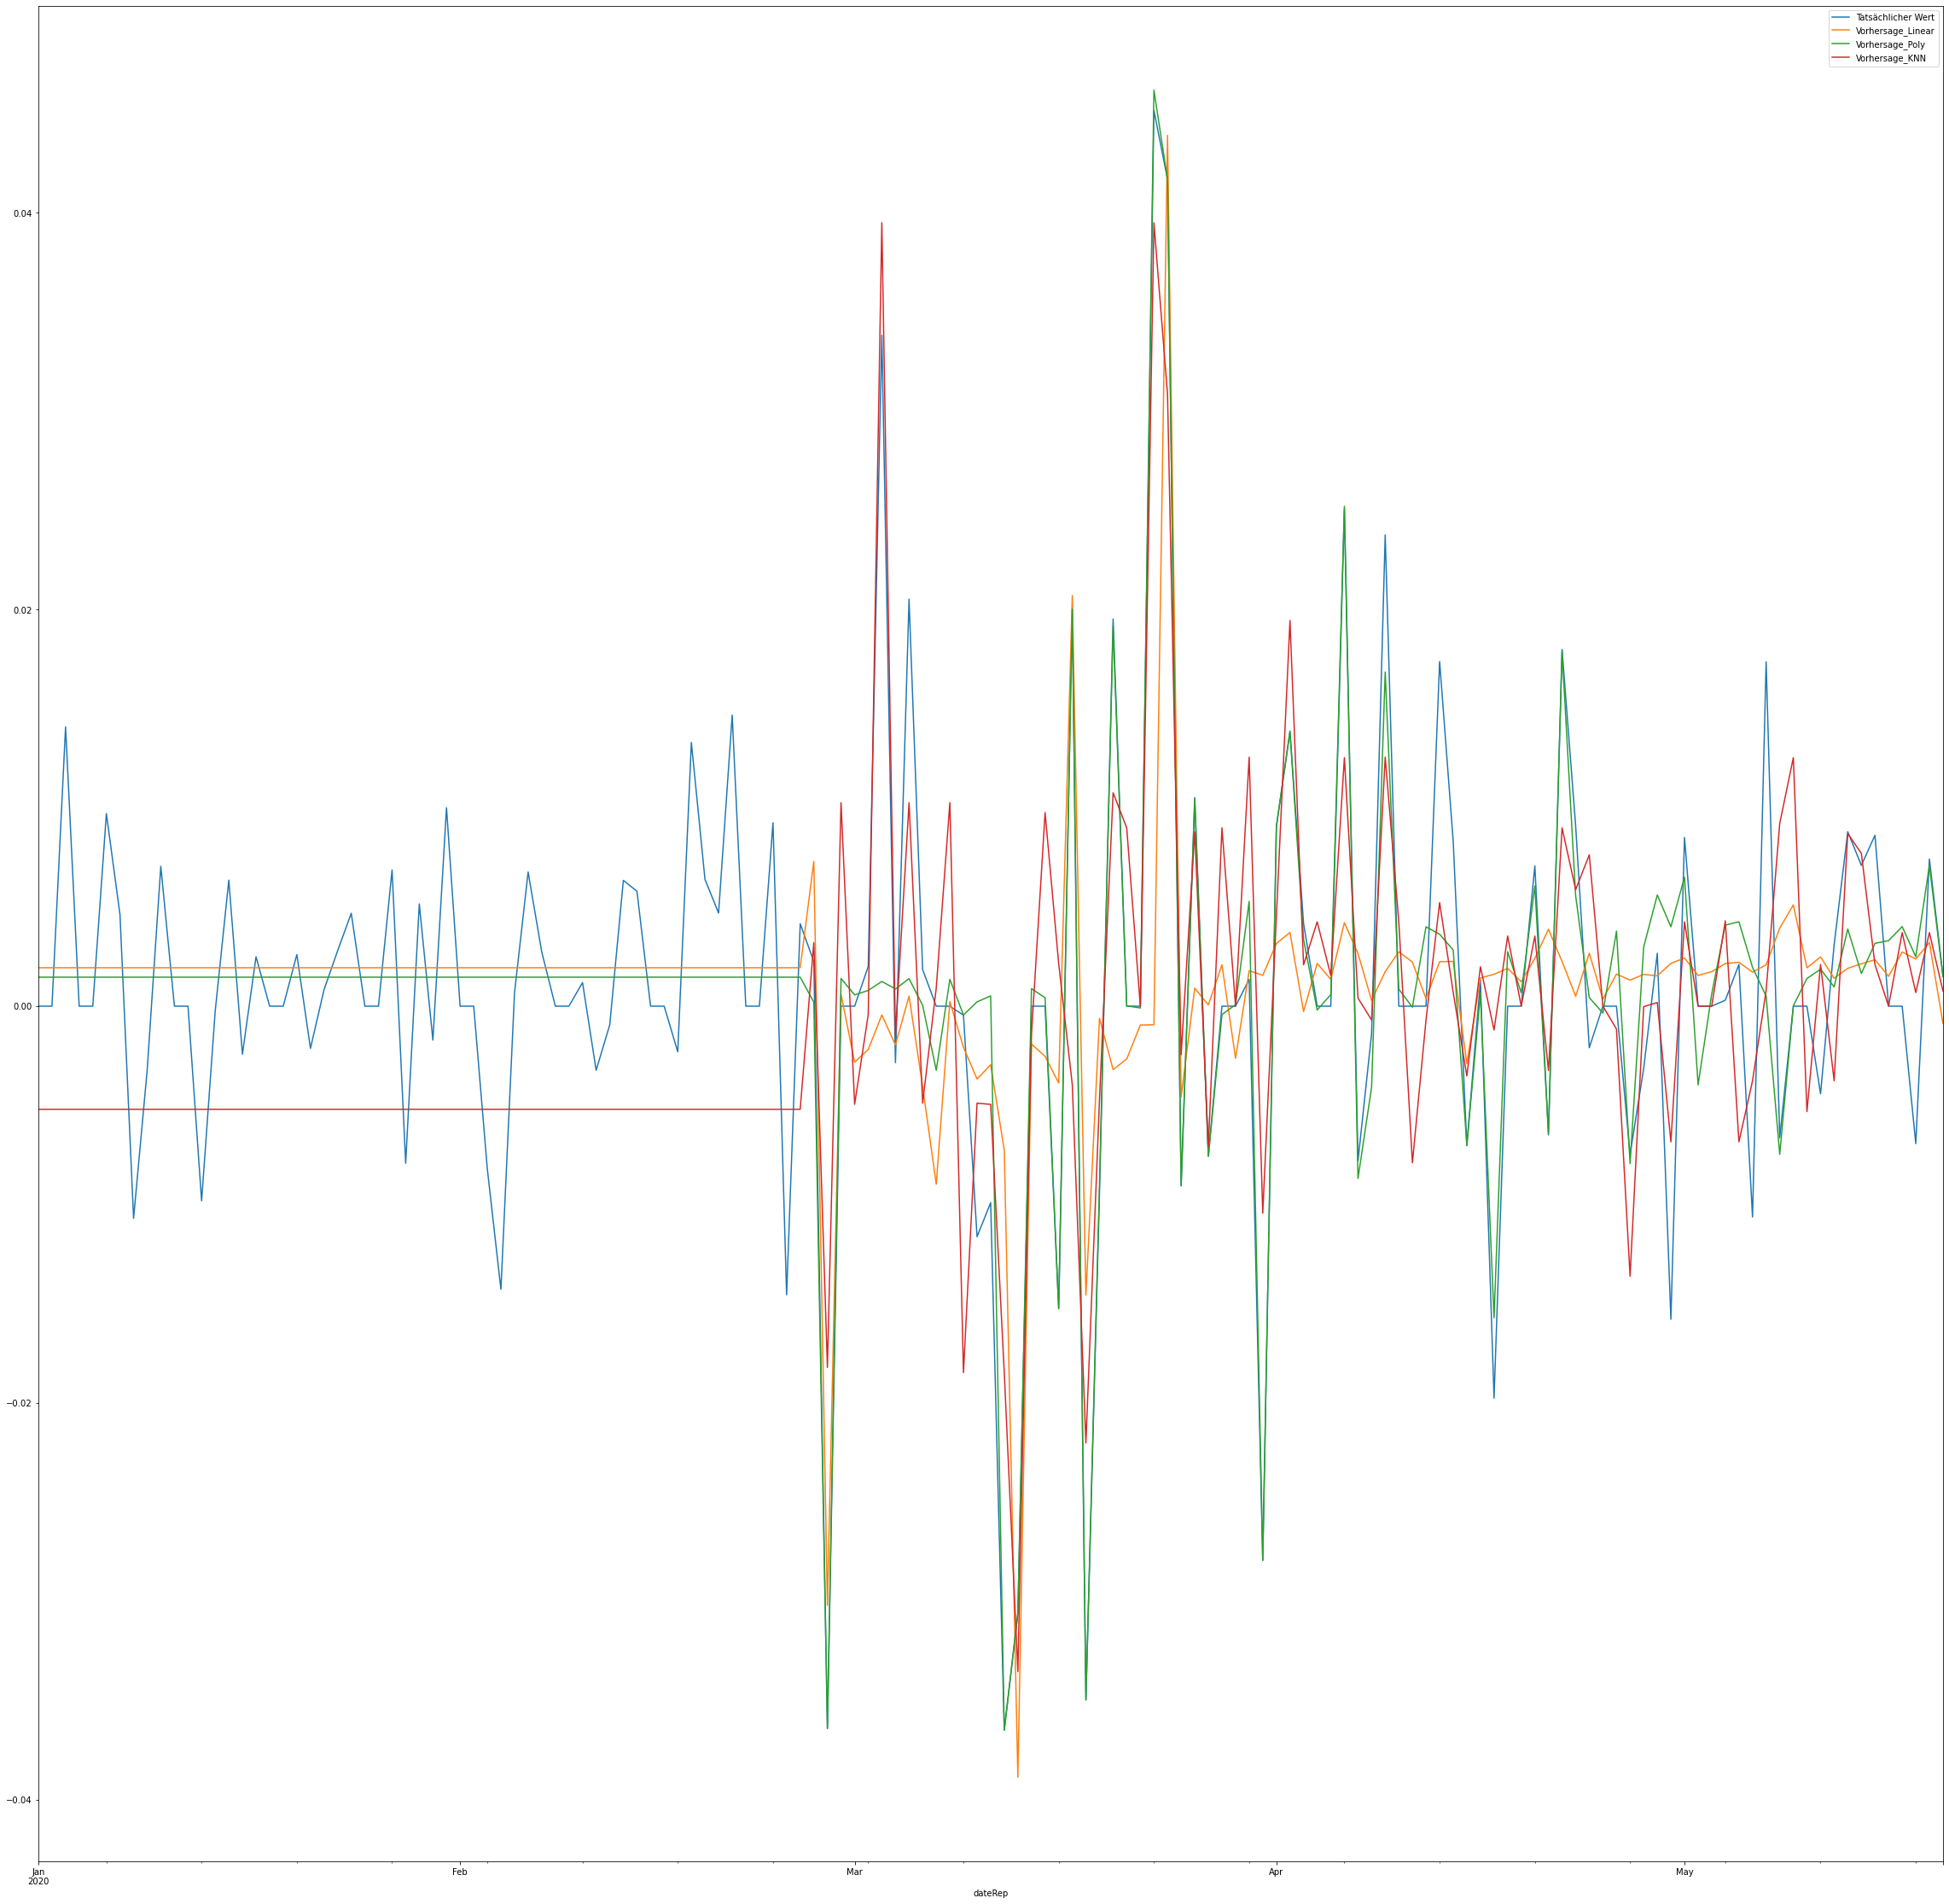

In [ ]:
#################################################################################################
#                                                                                               #
#   <Funktionsbeschreibung>  Unabhängige Variable Gold                                          #
#                                                                                               #
#   Dieses Programm wurde für den Kurs Data-Science 1 an der Goethe-Uni Frankfurt erstellt      #
#   Betreuender Dozent: Dr. Karsten Toll                                                        #
#   Projektgruppe:                                                                              #
#       - plumbus (Nr. 108)                                                                     #
#       - Simon Fischer-Heselhaus                                                               #
#       - Bahram Salimi                                                                         #
#                                                                                               #
#################################################################################################

import pandas as pd
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import glob

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

scaler = StandardScaler()

pd.set_option("display.max_rows", None, "display.max_columns", None)


#################################################################################################
#                                                                                               #
#   Einlesen der Datensätze                                                                     #
#                                                                                               #
#################################################################################################

# COVID-19 Falldaten von  https://data.europa.eu/euodp/de/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590
filenameCovid = '../plumbus_data/covid_cases.csv'
# Datensatz für ISO-Codes von https://www.oenb.at/Statistik/Klassifikationen/ISO-Codes/ISO-Code-Verzeichnis-fuer-Laender--und-Waehrungscodes.html
filenameIso = '../plumbus_data/IsoCodes.csv'
# Datensatz für Währungen von https://www.commerzbank.de/de/hauptnavigation/kunden/kursinfo/devisenk/ezb_referenzkurse/archiv_3/ezb_archiv.jsp
filenameCurrenciesRates = '../plumbus_data/ecb_rates_DE_compl.csv'
# Datensatz für Bitcoinkurs https://www.blockchain.com/charts/market-price
filenameBitcoinRates = '../plumbus_data/market-price.csv'
# Datensatz für Goldkurs von https://www.ariva.de/goldpreis-gold-kurs/historische_kurse?boerse_id=130 
filenameGoldRates = '../plumbus_data/wkn_965515_historic.csv'


dfCurrencies = pd.DataFrame()
dfCurrencies.insert(0, "Tagesdatum", [], True) 
dfCurrencies.insert(1, "Kalender-woche", [], True) 
for f in glob.glob("../plumbus_data/ecb_rates_DE*.xls"):
    dfCurr = pd.read_excel(f, skiprows=[0,1,2,4], header=0)
    dfCurrencies = pd.merge(dfCurrencies, dfCurr, left_on=["Tagesdatum","Kalender-woche"], right_on=["Tagesdatum","Kalender-woche"], how="right",)

dfCovid = pd.read_csv(filenameCovid, header=0, delimiter=",")
dropCovidColumns = ["day","month","year","deaths","countryterritoryCode","popData2018","continentExp"]

#Kurs von BGN  schwankt symmetrisch zu Euro-Kurs -> Keine Kursveränderung
dropCurrencies = ["BGN","Kalender-woche"]
dfCurrencies.drop(dropCurrencies,axis=1,inplace=True)

dfCovid.drop(dropCovidColumns,axis=1,inplace=True)
dfCovid = dfCovid.iloc[::-1]
dfCovid["dateRep"] = pd.to_datetime(dfCovid["dateRep"], format='%d/%m/%Y')

dfIso = pd.read_csv(filenameIso, header=1, usecols=["ISO-Code Land", "ISO-Code Währung"], delimiter=";")

dfBitcoin = pd.read_csv(filenameBitcoinRates, header=0, delimiter=",")

dfGold = pd.read_csv(filenameGoldRates, usecols=["Datum", "Schlusskurs"], header=0, delimiter=";")

caseSum=0
for i in range(len(dfCovid)): 
    if i < len(dfCovid) and dfCovid.iloc[i,2] == dfCovid.iloc[i-1,2]:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    elif i == 0:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    else:
        caseSum=0

dfCovid.set_index("dateRep", inplace=True)
dfCovid["CovidPctChange"] = dfCovid.groupby(["geoId"]).cases.pct_change()
dfCovid.reset_index(drop=False, inplace=True)
        
dfCurrencies.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfCurrencies.index=pd.to_datetime(dfCurrencies["Tagesdatum"], format="%d.%m.%Y")
dfCurrencies = dfCurrencies.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfCurrencies = dfCurrencies.iloc[:,1:].astype(float)
dfCurrencies = dfCurrencies.pct_change(fill_method='ffill')

dfCurrenciesCombined = dfCurrencies.mean(axis = 1, skipna = True)

dfBitcoin.index=pd.to_datetime(pd.DatetimeIndex(dfBitcoin["Timestamp"]).normalize(), format="")
dfBitcoin.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")

dfBitcoin = dfBitcoin.iloc[:,1:]
dfBitcoin = dfBitcoin.pct_change(fill_method ='ffill')
dfBitcoin.rename(columns={'market-price':'BitcoinPctChg'}, inplace=True)

dfGold.index=pd.to_datetime(pd.DatetimeIndex(dfGold["Datum"]).normalize(), format="%Y-%m-%d")
dfGold = dfGold.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfGold.index.name = 'Datum'
dfGold = dfGold.iloc[:,1:].replace({'[.]':'','[,]':'.'}, regex=True).astype(float)
dfGold = dfGold.pct_change(fill_method='ffill')
dfGold.rename(columns={'Schlusskurs':'GoldPctChg'}, inplace=True)

dfCovid.set_index("dateRep", inplace=True)
dfCovid.drop(["cases","geoId"],axis=1,inplace=True)
dfCovid.fillna(0, inplace=True)
dfCovid = dfCovid[~dfCovid.isin([np.nan, np.inf, -np.inf]).any(1)]

dfBitcoin = dfBitcoin[~dfBitcoin.isin([np.nan, np.inf, -np.inf]).any(1)]
dfBitcoin.fillna(0, inplace=True)

dfGold = dfGold[~dfGold.isin([np.nan, np.inf, -np.inf]).any(1)]
dfGold.fillna(0, inplace=True)

dfCovid_pivot = dfCovid.pivot_table(index="dateRep", columns="countriesAndTerritories", values="CovidPctChange", fill_value=0)
dfCovidBitcoin_pivot = pd.merge(dfCovid_pivot, dfBitcoin, left_index=True, right_index=True, how='left') #, right_on='Timestamp'
dfCovidBitcoinGold_pivot = pd.merge(dfCovidBitcoin_pivot, dfGold, left_index=True, right_index=True,how='left') #, right_on='Datum'
dfCovidBitcoinGold_pivot.fillna(0, inplace=True)

y_gold = dfCovidBitcoinGold_pivot["GoldPctChg"]
x_gold = dfCovidBitcoinGold_pivot[["Jamaica", "Austria", "Bulgaria", "Venezuela", "Benin"]] # Länder mit höchster |Korr.| zu Goldkurs

#################################################################################################
#                                                                                               #
#   Prognosemodelle                                                                             #
#                                                                                               #
#################################################################################################

linReg_gold = LinearRegression()
linReg_gold.fit(x_gold, y_gold)
yPred_gold = linReg_gold.predict(x_gold)
confiReg_gold = linReg_gold.score(x_gold, y_gold)

neighbors = 2 #k: Score => 2: 0.43840015468731863, 3: 0.4327363299656044, 4: 0.329244782700012
kNeigh_gold = KNeighborsRegressor(n_neighbors=neighbors)
kNeigh_gold.fit(x_gold, y_gold)
kNNPred_gold = kNeigh_gold.predict(x_gold)
confiKnn_gold = kNeigh_gold.score(x_gold, y_gold)

polyDegree = 3
polyReg_gold = PolynomialFeatures(degree=polyDegree) #Polynomgrad: Score => 5: 0.8269004792346912, 4: 0.7991633800180653, 3: 0.7150036888999993, 2: 0.46665070433950484
xPoly_gold = polyReg_gold.fit_transform(x_gold)
polyLinReg_gold = LinearRegression()
polyLinReg_gold.fit(xPoly_gold, y_gold)
yPolyPred_gold = polyLinReg_gold.predict(xPoly_gold)
confiPoly_gold = polyLinReg_gold.score(xPoly_gold, y_gold)

print("Konfidenz der linearen Regression: ", confiReg_gold, "\nKNN-Konfidenz (mit", neighbors, "Nachbarn): ", confiKnn_gold, "\nKonfidenz der polynomiale Regression (", polyDegree, ". Grades): ", confiPoly_gold)

df = pd.DataFrame({'Tatsächlicher Wert': y_gold, 'Vorhersage_Linear': yPred_gold, 'Vorhersage_Poly': yPolyPred_gold, 'Vorhersage_KNN': kNNPred_gold})
df.plot(figsize=(40,40))


## 2.2: Unabhängige Variable Bitcoin
Aus 1.4.1 sind die Länder mit den höchsten Korrelationen zwischen COVID-Fällen und Bitcoinkurs bekannt. Auch hier nutzen wir nur Länder, deren Korrelation mindestens |0,3| beträgt. Dies sind Brunei_Darussalam, Qatar, Armenia, Cyprus, Sri_Lanka, Russia, Morocco, Colombia. Im Vergleich schneidet erneut die polynomiale Regression am besten ab. Mit einem Grad von 3 ist die Konfidenz bereits relativ hoch und höher als die Konfidenz der obigen Gold-Modelle.

Konfidenz der linearen Regression:  0.40005813190236783 
KNN-Konfidenz (mit 2 Nachbarn):  0.4783919357756973 
Konfidenz der polynomiale Regression ( 3 . Grades):  0.8653473118730878


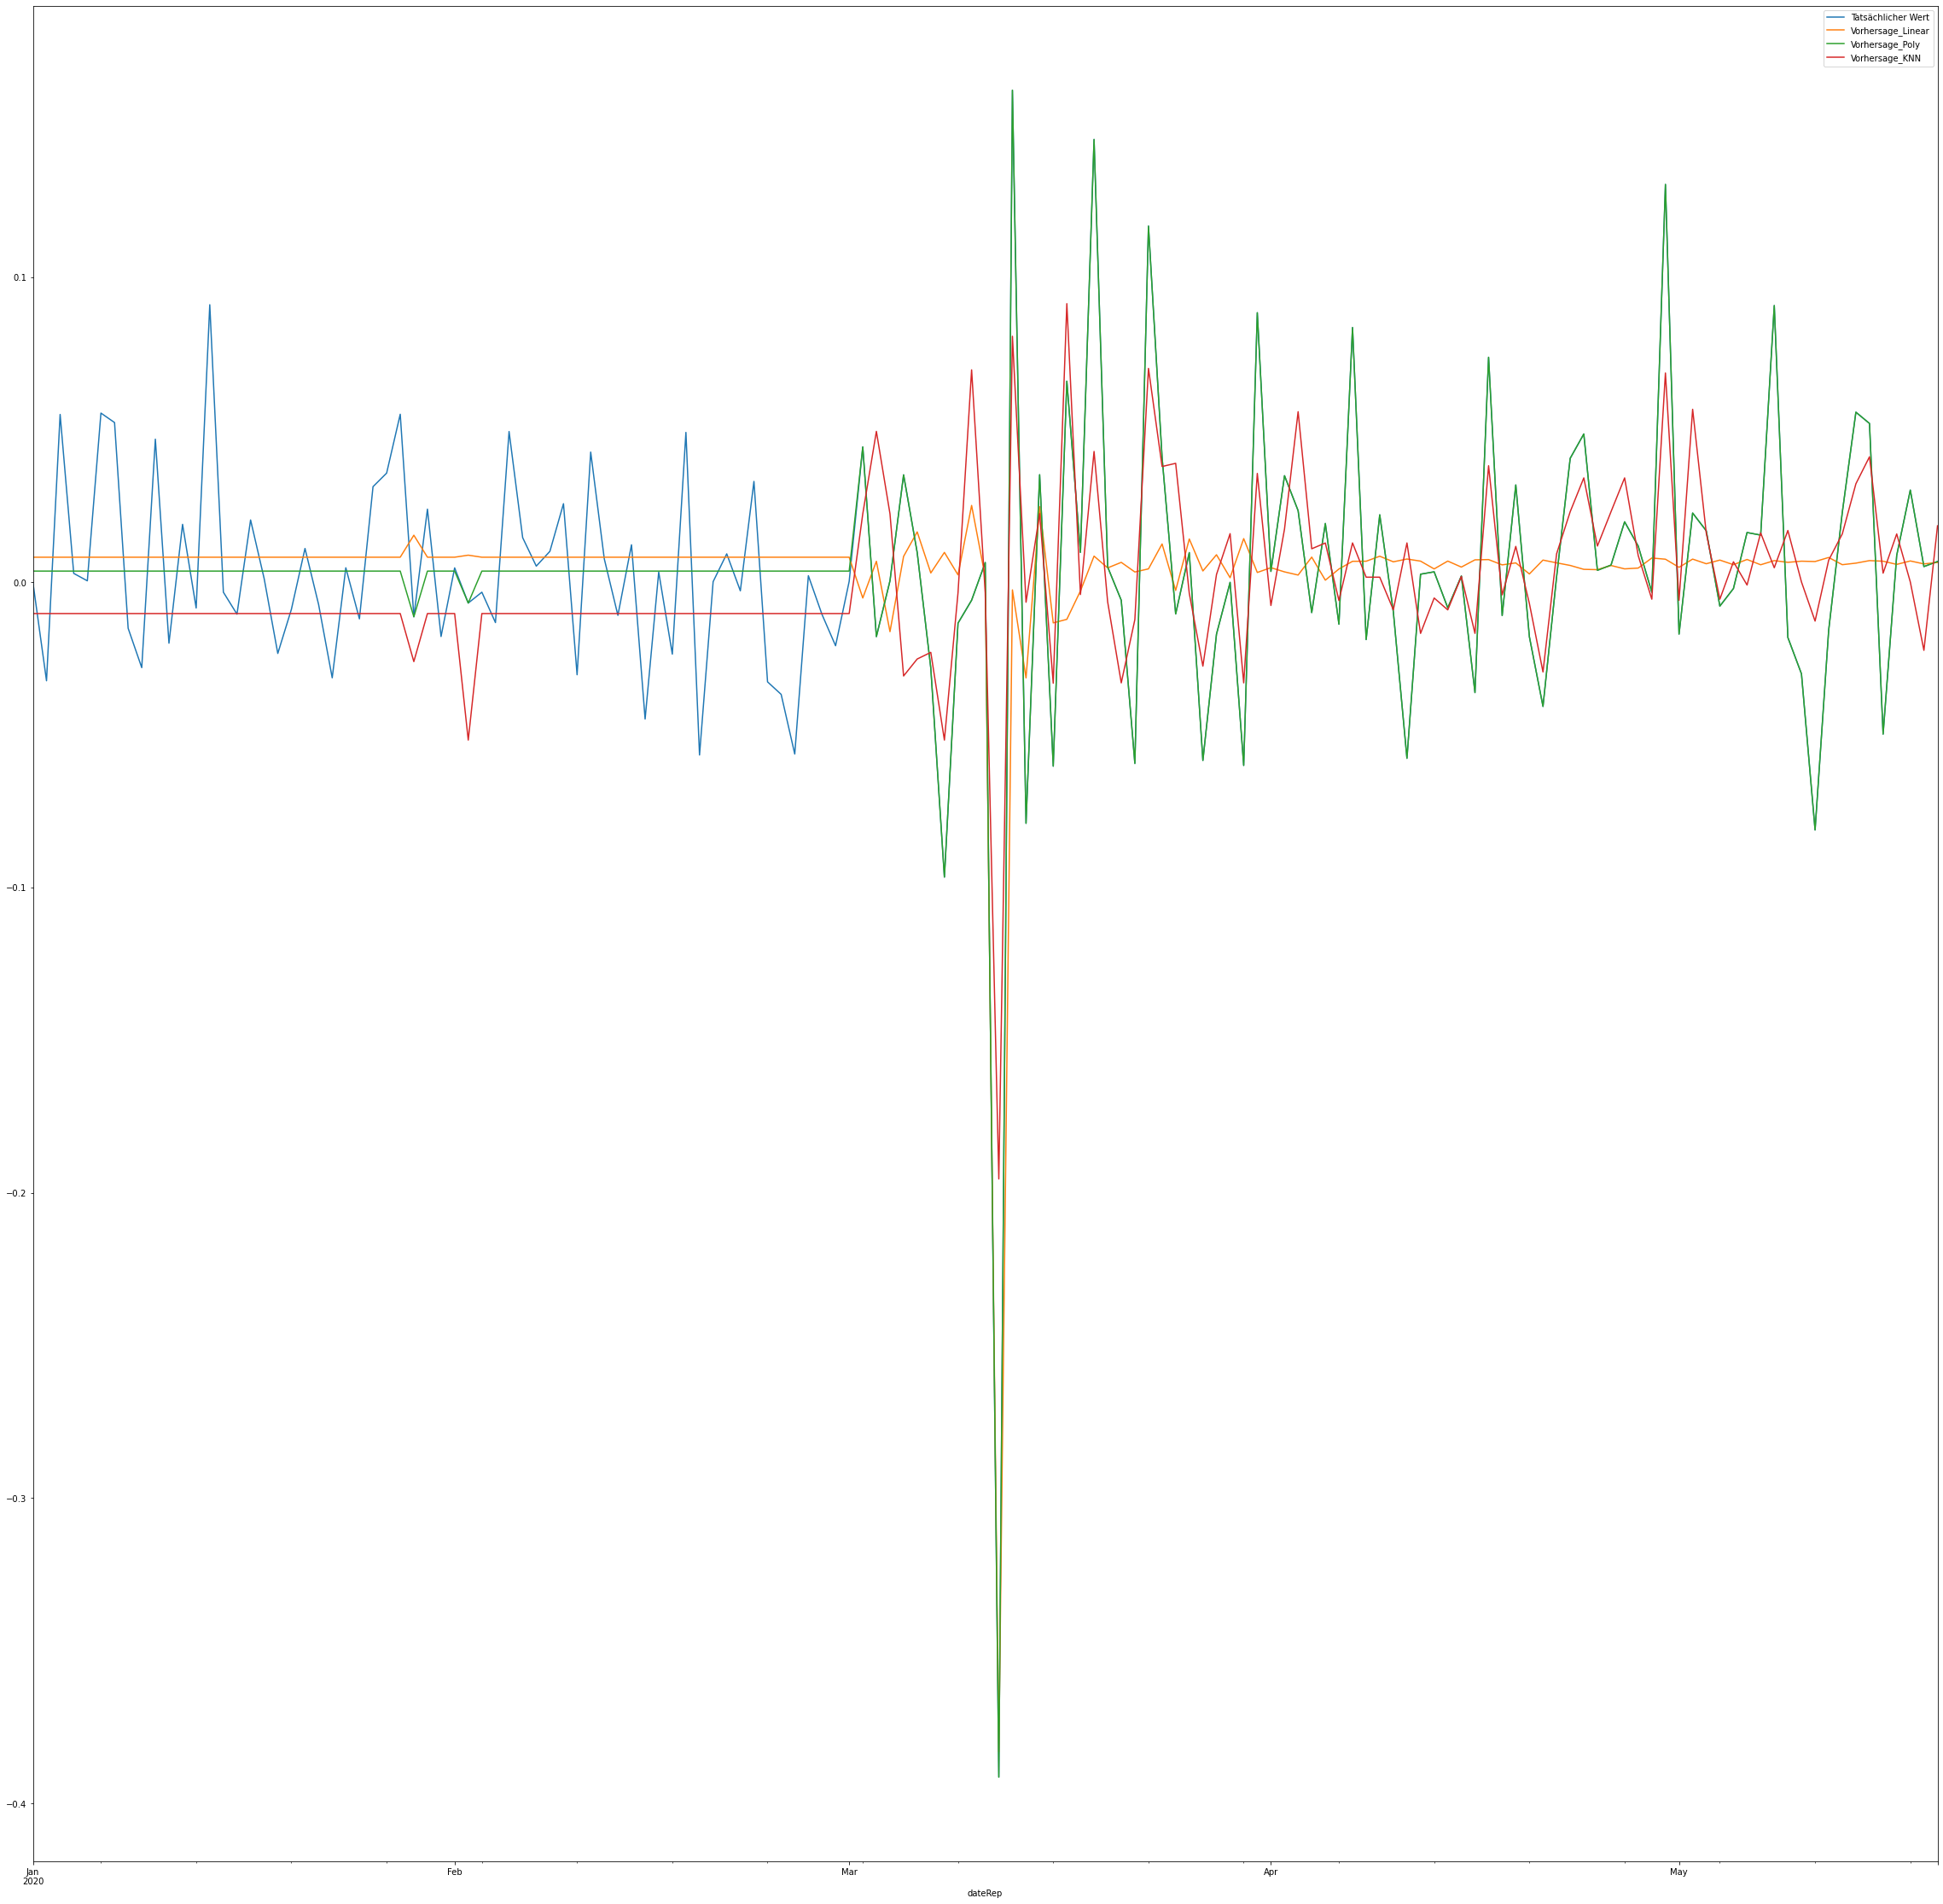

In [ ]:
#################################################################################################
#                                                                                               #
#   <Funktionsbeschreibung>  Unabhängige Variable Bitcoin                                       #
#                                                                                               #
#   Dieses Programm wurde für den Kurs Data-Science 1 an der Goethe-Uni Frankfurt erstellt      #
#   Betreuender Dozent: Dr. Karsten Toll                                                        #
#   Projektgruppe:                                                                              #
#       - plumbus (Nr. 108)                                                                     #
#       - Simon Fischer-Heselhaus                                                               #
#       - Bahram Salimi                                                                         #
#                                                                                               #
#################################################################################################

import pandas as pd
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import glob

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

scaler = StandardScaler()

pd.set_option("display.max_rows", None, "display.max_columns", None)


#################################################################################################
#                                                                                               #
#   Einlesen der Datensätze                                                                     #
#                                                                                               #
#################################################################################################

# COVID-19 Falldaten von  https://data.europa.eu/euodp/de/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590
filenameCovid = '../plumbus_data/covid_cases.csv'
# Datensatz für ISO-Codes von https://www.oenb.at/Statistik/Klassifikationen/ISO-Codes/ISO-Code-Verzeichnis-fuer-Laender--und-Waehrungscodes.html
filenameIso = '../plumbus_data/IsoCodes.csv'
# Datensatz für Währungen von https://www.commerzbank.de/de/hauptnavigation/kunden/kursinfo/devisenk/ezb_referenzkurse/archiv_3/ezb_archiv.jsp
filenameCurrenciesRates = '../plumbus_data/ecb_rates_DE_compl.csv'
# Datensatz für Bitcoinkurs https://www.blockchain.com/charts/market-price
filenameBitcoinRates = '../plumbus_data/market-price.csv'
# Datensatz für Goldkurs von https://www.ariva.de/goldpreis-gold-kurs/historische_kurse?boerse_id=130 
filenameGoldRates = '../plumbus_data/wkn_965515_historic.csv'


dfCurrencies = pd.DataFrame()
dfCurrencies.insert(0, "Tagesdatum", [], True) 
dfCurrencies.insert(1, "Kalender-woche", [], True) 
for f in glob.glob("../plumbus_data/ecb_rates_DE*.xls"):
    dfCurr = pd.read_excel(f, skiprows=[0,1,2,4], header=0)
    dfCurrencies = pd.merge(dfCurrencies, dfCurr, left_on=["Tagesdatum","Kalender-woche"], right_on=["Tagesdatum","Kalender-woche"], how="right",)

dfCovid = pd.read_csv(filenameCovid, header=0, delimiter=",")
dropCovidColumns = ["day","month","year","deaths","countryterritoryCode","popData2018","continentExp"]

#Kurs von BGN  schwankt symmetrisch zu Euro-Kurs -> Keine Kursveränderung
dropCurrencies = ["BGN","Kalender-woche"]
dfCurrencies.drop(dropCurrencies,axis=1,inplace=True)

dfCovid.drop(dropCovidColumns,axis=1,inplace=True)
dfCovid = dfCovid.iloc[::-1]
dfCovid["dateRep"] = pd.to_datetime(dfCovid["dateRep"], format='%d/%m/%Y')

dfIso = pd.read_csv(filenameIso, header=1, usecols=["ISO-Code Land", "ISO-Code Währung"], delimiter=";")

dfBitcoin = pd.read_csv(filenameBitcoinRates, header=0, delimiter=",")

dfGold = pd.read_csv(filenameGoldRates, usecols=["Datum", "Schlusskurs"], header=0, delimiter=";")

caseSum=0
for i in range(len(dfCovid)): 
    if i < len(dfCovid) and dfCovid.iloc[i,2] == dfCovid.iloc[i-1,2]:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    elif i == 0:
        caseSum = caseSum + dfCovid.iloc[i,1]
        dfCovid.iloc[i,1] = dfCovid.iloc[i,1] + caseSum
    else:
        caseSum=0

dfCovid.set_index("dateRep", inplace=True)
dfCovid["CovidPctChange"] = dfCovid.groupby(["geoId"]).cases.pct_change()
dfCovid.reset_index(drop=False, inplace=True)
        
dfCurrencies.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfCurrencies.index=pd.to_datetime(dfCurrencies["Tagesdatum"], format="%d.%m.%Y")
dfCurrencies = dfCurrencies.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfCurrencies = dfCurrencies.iloc[:,1:].astype(float)
dfCurrencies = dfCurrencies.pct_change(fill_method='ffill')

dfCurrenciesCombined = dfCurrencies.mean(axis = 1, skipna = True)

dfBitcoin.index=pd.to_datetime(pd.DatetimeIndex(dfBitcoin["Timestamp"]).normalize(), format="")
dfBitcoin.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")

dfBitcoin = dfBitcoin.iloc[:,1:]
dfBitcoin = dfBitcoin.pct_change(fill_method ='ffill')
dfBitcoin.rename(columns={'market-price':'BitcoinPctChg'}, inplace=True)

dfGold.index=pd.to_datetime(pd.DatetimeIndex(dfGold["Datum"]).normalize(), format="%Y-%m-%d")
dfGold = dfGold.reindex(pd.date_range("01.01.2020", "20.05.2020"), fill_value="NaN")
dfGold.index.name = 'Datum'
dfGold = dfGold.iloc[:,1:].replace({'[.]':'','[,]':'.'}, regex=True).astype(float)
dfGold = dfGold.pct_change(fill_method='ffill')
dfGold.rename(columns={'Schlusskurs':'GoldPctChg'}, inplace=True)

dfCovid.set_index("dateRep", inplace=True)
dfCovid.drop(["cases","geoId"],axis=1,inplace=True)
dfCovid.fillna(0, inplace=True)
dfCovid = dfCovid[~dfCovid.isin([np.nan, np.inf, -np.inf]).any(1)]

dfBitcoin = dfBitcoin[~dfBitcoin.isin([np.nan, np.inf, -np.inf]).any(1)]
dfBitcoin.fillna(0, inplace=True)

dfGold = dfGold[~dfGold.isin([np.nan, np.inf, -np.inf]).any(1)]
dfGold.fillna(0, inplace=True)

dfCovid_pivot = dfCovid.pivot_table(index="dateRep", columns="countriesAndTerritories", values="CovidPctChange", fill_value=0)
dfCovidBitcoin_pivot = pd.merge(dfCovid_pivot, dfBitcoin, left_index=True, right_index=True, how='left') #, right_on='Timestamp'
dfCovidBitcoinGold_pivot = pd.merge(dfCovidBitcoin_pivot, dfGold, left_index=True, right_index=True,how='left') #, right_on='Datum'
dfCovidBitcoinGold_pivot.fillna(0, inplace=True)

y_bc = dfCovidBitcoinGold_pivot["BitcoinPctChg"]
x_bc = dfCovidBitcoinGold_pivot[["Brunei_Darussalam", "Qatar", "Armenia", "Cyprus", "Sri_Lanka", "Russia", "Morocco", "Colombia"]]


linReg_bc = LinearRegression()
linReg_bc.fit(x_bc, y_bc)
yPred_bc = linReg_bc.predict(x_bc)
confiReg_bc = linReg_bc.score(x_bc, y_bc)

neighbors = 2 #k: Score => 2: 0.4783919357756973, 3: 0.3016010163972407, 4: 0.2546401027618206
kNeigh_bc = KNeighborsRegressor(n_neighbors=neighbors)
kNeigh_bc.fit(x_bc, y_bc)
kNNPred_bc = kNeigh_bc.predict(x_bc)
confiKnn_bc = kNeigh_bc.score(x_bc, y_bc)

polyDegree = 3
polyReg_bc = PolynomialFeatures(degree=polyDegree) #Polynomgrad: Score => 6: 0.865327246291669, 5: 0.865327246309772, 4: 0.8653272463100234, 3: 0.8611899253778172, 2: 0.7081121039908214
xPoly_bc = polyReg_bc.fit_transform(x_bc)
polyLinReg_bc = LinearRegression()
polyLinReg_bc.fit(xPoly_bc, y_bc)
yPolyPred_bc = polyLinReg_bc.predict(xPoly_bc)
confiPoly_bc = polyLinReg_bc.score(xPoly_bc, y_bc)

print("Konfidenz der linearen Regression: ", confiReg_bc, "\nKNN-Konfidenz (mit", neighbors, "Nachbarn): ", confiKnn_bc, "\nKonfidenz der polynomiale Regression (", polyDegree, ". Grades): ", confiPoly_bc)

df = pd.DataFrame({'Tatsächlicher Wert': y_bc, 'Vorhersage_Linear': yPred_bc, 'Vorhersage_Poly': yPolyPred_bc, 'Vorhersage_KNN': kNNPred_bc})
df.plot(figsize=(40,40))

# Teil 3: Fragen, Kritik und Tipps

## 3.1: Methodik
Die hier verwendeten statistischen Verfahren weisen einige Probleme auf, so wurden beispielsweise "Ausreißer" nicht gesondert berücksichtigt. Außerdem wurde die Signifikanz der Korrelationen nicht einbezogen. Da im Bereich Data Science häufig große Datenmengen verwertet werden, scheint die Signifikanz standardmäßig gegeben zu sein. In diesem Zusammenhang kam es öfter zu falschen Korrelationen, wenn fehlende Daten nicht aufgefüllt wurden. COVID trat beispielsweise in jedem Land zu einem anderen Zeitpunkt auf, demnach gibt es, im vorliegenden Datensatz, teilweise große Lücken.
## 3.2: Domänenwissen
Wir verfügen nur über eingeschränktes Domänenwissen. Trotzdem gibt es einige Faktoren, die nicht eingeflossen sind: Alle Werte werden in Bezug auf andere Werte gemessen. Wir sind davon ausgegangen, dass der Euro relativ stabil ist. In Realität schwankt der Eurokurs ebenfalls, dies wurde allerdings nicht berücksichtigt. Ebenfalls nicht berücksichtigt wurden Zeitreiheneffekte (https://de.wikipedia.org/wiki/Zeitreihenanalyse).

## 3.3: COVID: Angst vor Kausalität und Dunkelziffer
Die Messung von COVID-Fällen ist äußerst problematisch. In einigen Ländern gibt es geringe Testkapazitäten, gerade am Anfang der Pandemie wurde teilweise gar nicht getestet, China hat im Februar die Zählweise von Infizierten verändert - und plötzlich verzehnfachte sich die Zahl neuer Fälle (https://www.tagesschau.de/ausland/coronavirus-209.html). Die Dunkelziffer an COVID-Erkrankten ist folglich von Land zu Land unterschiedlich. Es wird spekuliert, dass in einigen Ländern wie Russland (https://www.deutschlandfunk.de/coronavirus-zweifel-an-niedriger-covid-19-sterblichkeit-in.1773.de.html?dram:article_id=476943) und China (https://www.tagesschau.de/ausland/china-corona-wurzel-korri-101.html) die Zahl der Erkrankten bewusst nach unten korrigiert wird, um politische und wirtschaftliche Negativentwicklungen zu vermeiden. An dieser Stelle lohnt es sich wohl (ausnahmsweise) Donald Trump zu zitieren: "If we stop testing right now, we'd have very few cases, if any" (https://www.independent.co.uk/news/world/americas/us-politics/trump-latest-coronavirus-cases-usa-update-testing-numbers-a9567566.html)

## 3.4: Weitere Analysemöglichkeiten
Mangels Zeit konnten viele Daten nicht berücksichtigt werden. Abgesehen von den in 3.1-3.3 genannten nicht verwerteten oder nicht beachteten Daten, hätten beispielsweise die Prognosemodelle mit den tatsächlichen Entwicklungen verglichen werden können. Des Weiteren wäre es auch möglich gewesen weitere Analysen der Heatmap oder der Streudiagramme durchzuführen, bspw. Mit Scagnostics (https://de.wikipedia.org/wiki/Scagnostics)

## 3.5: Tipps
<ol>
    <li>Datensätze sollten nach jedem Verarbeitungsschritt auf Vollständigkeit und Sinnhaftigkeit überprüft werden. </li>
    <li>Domänenwissen sollte berücksichtigt werden</li>
    <li>Im Gebiet der Data Science wird oft von einer automatischen Signifikanz der Ergebnisse ausgegangen, da in der Regel auf große Datenmengen zurückgegriffen wird. Weitere statistische Verfahren (p-Test etc.), gerade bei lückenhaften Daten, können sinnvoll sein. </li>
    <li> Und: Korrelation ist nicht Kausalität </li>
</ol>

## 3.6 Fazit
Zwar konnten wir einige interessante Ergebnisse generieren, allerdings ist deren Validität, unter Berücksichtigung der oben genannten Probleme, fragwürdig. Eine andere Herangehensweise hätte eventuell zielführender sein können.